In [1]:
# !pip install -q shap scipy pandas matplotlib seaborn fastcore

## Imports and utilities

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy import stats

from IPython.display import display, HTML

np.random.seed(42)

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.rc('font', family='serif')
mpl.rcParams['figure.dpi'] = 300

IMG_DIR = Path('../images')
IMG_DIR.mkdir(exist_ok=True, parents=True)

def savefig(name, **kwargs):
    params = dict(bbox_inches='tight', transparent="True", pad_inches=0)
    params.update(kwargs)
    plt.savefig(IMG_DIR / f"{name}.png", **params)


In [4]:
from fastcore.basics import patch_to

@patch_to(pd.DataFrame)
def display(self, **kwargs): 
    display(HTML(self.to_html(**kwargs)))

def logical_and(*args):
    if len(args) == 1:
        return args[0]
    return np.logical_and(*args)

def groupby(iterable, key_func, val_func=None):
    res = dict()
    for elem in iterable:
        key = key_func(elem)
        value = val_func(elem) if val_func else elem
        grp = res.get(key, [])
        grp.append(value)
        res[key] = grp
    return res

def get_numerical_cols(dataf):
    return dataf.select_dtypes('number').columns.tolist()

def get_ordinal_cols(dataf):
    return [col for col in dataf.select_dtypes('category').columns if dataf[col].dtypes.ordered]

def get_nominal_cols(dataf):
    return [col for col in dataf.select_dtypes('category').columns if not dataf[col].dtypes.ordered]

## Data cleaning

In [5]:
TARGETS = ['OverallQual']
UNUSED = ['SalePrice', 'YrSold', 'MoSold', 'SaleCondition']

In [6]:
ORDINALS_INFO = [
    ('BsmtExposure',['NA', 'No', 'Mn', 'Av', 'Gd']),
    ('BsmtQual',['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('BsmtCond', ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('ExterQual',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('ExterCond', ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('FireplaceQu',['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageCond',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageQual',['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('HeatingQC',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('KitchenQual',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('LandSlope',['Gtl', 'Mod', 'Sev']),
    ('PoolQC', ['NA', 'Fa', 'TA', 'Gd', 'Ex']),
    ('OverallQual', list(range(1, 11))),
    ('OverallCond', list(range(1, 11))),
    ('MoSold', list(range(1,13))),
    ('YrSold', None),
    ('YearBuilt', None),
    ('YearRemodAdd', None),
    ('GarageYrBlt', None),
]
ORDINALS = [feat for feat, _ in ORDINALS_INFO]

NOMINALS = [
    'Alley',
    'BldgType',
    'BsmtFinType1',
    'BsmtFinType2',
    'CentralAir',
    'Condition1',
    'Condition2',
    'Electrical',
    'Exterior1st',
    'Exterior2nd',
    'Fence',
    'Foundation',
    'Functional',
    'GarageFinish',
    'GarageType',
    'Heating',
    'HouseStyle',
    'LandContour',
    'LotConfig',
    'LotShape',
    'MSSubClass',
    'MSZoning',
    'MasVnrType',
    'MiscFeature',
    'Neighborhood',
    'PavedDrive',
    'RoofMatl',
    'RoofStyle',
    'SaleCondition',
    'SaleType',
    'Street',
    'Utilities'
]

NUMERICALS = [
    '1stFlrSF',
    '2ndFlrSF',
    '3SsnPorch',
    'BedroomAbvGr',
    'BsmtUnfSF',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtFullBath',
    'BsmtHalfBath',
    'EnclosedPorch',
    'Fireplaces',
    'FullBath',
    'GarageArea',
    'GarageCars',
    'GrLivArea',
    'HalfBath',
    'KitchenAbvGr',
    'LotArea',
    'LotFrontage',
    'LowQualFinSF',
    'MasVnrArea',
    'MiscVal',
    'OpenPorchSF',
    'PoolArea',
    'ScreenPorch',
    'TotRmsAbvGrd',
    'TotalBsmtSF',
    'WoodDeckSF',
    'SalePrice'
]


VAR_TYPE_MAP = {
    col: t 
    for t, cols in [('numerical', NUMERICALS), ('ordinal', ORDINALS), ('nominal', NOMINALS)] 
    for col in cols
}

def find_inconsistencies(dataf):
    logical_checks = dict([
        ('YearBuilt', lambda dataf: dataf['YearBuilt'] < 1500),
        ('YearRemodAdd', lambda dataf: dataf['YearRemodAdd'] < 1500),
        ('GarageYrBlt', lambda dataf: dataf['GarageYrBlt'] < 1500),
        ('YrSold', lambda dataf: (
            (dataf['YrSold'] < 2000) \
            | (~dataf['YearBuilt'].isna() & ~dataf['YrSold'].isna() & (dataf['YrSold'] < dataf['YearBuilt']))
        )),
    ])

    for col, category_values in ORDINALS_INFO: 
        if col not in dataf.columns:
            continue
        if category_values is None:
            continue
        mask = (~dataf[col].isna() & ~dataf[col].isin(category_values))
        n_inconsistent = mask.sum()
        if n_inconsistent == 0:
            continue
        yield (col, mask)

    for col, predicate in logical_checks.items(): 
        if col not in dataf.columns:
            continue
        mask = (~dataf[col].isna() & predicate(dataf))
        n_inconsistent = mask.sum()
        if n_inconsistent == 0:
            continue
        yield (col, mask)
    
    for col in NUMERICALS:
        if col not in dataf.columns:
            continue
        mask = (~dataf[col].isna() & (dataf[col] < 0))
        n_inconsistent = mask.sum()
        if n_inconsistent == 0:
            continue
        yield (col, mask)
    
def erase_inconsistencies(dataf):
    dataf = dataf.copy()
    col_inconsistencies = {
        col: logical_and(*[mask.values for mask in masks]) 
        for col, masks in groupby(find_inconsistencies(dataf), key_func = lambda t: t[0], val_func = lambda t: t[1]).items()
    }
    for col, mask in col_inconsistencies.items():
        n_inconsistent = mask.sum()
        print(f"{n_inconsistent} inconsistent values found in {col}")
        dataf[mask].display()
        dataf.loc[mask, col] = np.nan
    
    return dataf

def drop_rows_missing_target(dataf, targets):
    if not np.all([col in dataf.columns for col in targets]):
        return dataf
    size = len(dataf)
    dataf = dataf.dropna(axis=0, how='any', subset=targets)
    new_size = len(dataf)
    n_dropped = size - new_size
    if n_dropped > 0:
        print(f'Dropped {n_dropped} rows missing target variables')
    return dataf

def fill_missing_values_by_data_description(dataf):
    dataf = dataf.copy()
    for col in ORDINALS + NOMINALS:
        if col not in dataf.columns:
            continue
        val = 'NA' if col != 'MasVnrType' else 'None'
        dataf[col] = dataf[col].fillna(val)
    return dataf

def prepare_dataset(dataf):
    dataf = (dataf
        .drop(columns=UNUSED, errors='ignore')
        .pipe(drop_rows_missing_target, targets=TARGETS)
        .pipe(erase_inconsistencies)
        .pipe(fill_missing_values_by_data_description)
    )

    for col in NUMERICALS:
        if col not in dataf.columns:
            continue
        dataf[col] = dataf[col].astype('float')
    
    for col, categories in ORDINALS_INFO:
        if col not in dataf.columns:
            continue
        dataf[col] = dataf[col].astype(CategoricalDtype(categories=categories, ordered=True))
    
    for col in NOMINALS:
        if col not in dataf.columns:
            continue
        dataf[col] = dataf[col].astype('category')
    
    existing_cols = set(dataf.columns)
    col_order =  [col for col in NUMERICALS + ORDINALS + NOMINALS if col in existing_cols]
    return dataf[col_order]

In [7]:
from sklearn.model_selection import train_test_split

data_dir = Path('.')

df = pd.read_csv(data_dir / 'train.csv', low_memory=False, index_col='Id').pipe(prepare_dataset)
x_train, y_train = df.drop(columns=TARGETS), df[TARGETS]

test_df = pd.read_csv(data_dir / 'test.csv', low_memory=False, index_col='Id').pipe(prepare_dataset)
x_test, y_test = test_df.drop(columns=TARGETS), test_df[TARGETS]


## Feature engineering

We will apply PCA on numerical variables to reduce dimensionality of our dataset.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

def make_preprocessor_for_pca(x_train):
    numerical_cols = get_numerical_cols(x_train)

    skewness = x_train[numerical_cols].skew()
    sym_numerical_cols = sorted(skewness[skewness.abs() <= 0.5].index.tolist())
    sym_transformer  = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
    ])

    skw_numerical_cols = sorted(list(set(numerical_cols).difference(sym_numerical_cols)))
    skw_transformer  = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = Pipeline([
        ('numerical', ColumnTransformer([ ('sym', sym_transformer, sym_numerical_cols), ('skw', skw_transformer, skw_numerical_cols)], remainder='drop')), 
        ('pca', PCA()),
    ])
    return preprocessor

pp_pca = make_preprocessor_for_pca(x_train)
x_train_nums_pca = pp_pca.fit_transform(x_train)
pca = pp_pca.steps[-1][1]

icomps = range(1, x_train_nums_pca.shape[-1]+1)
vrs = pca.explained_variance_ratio_


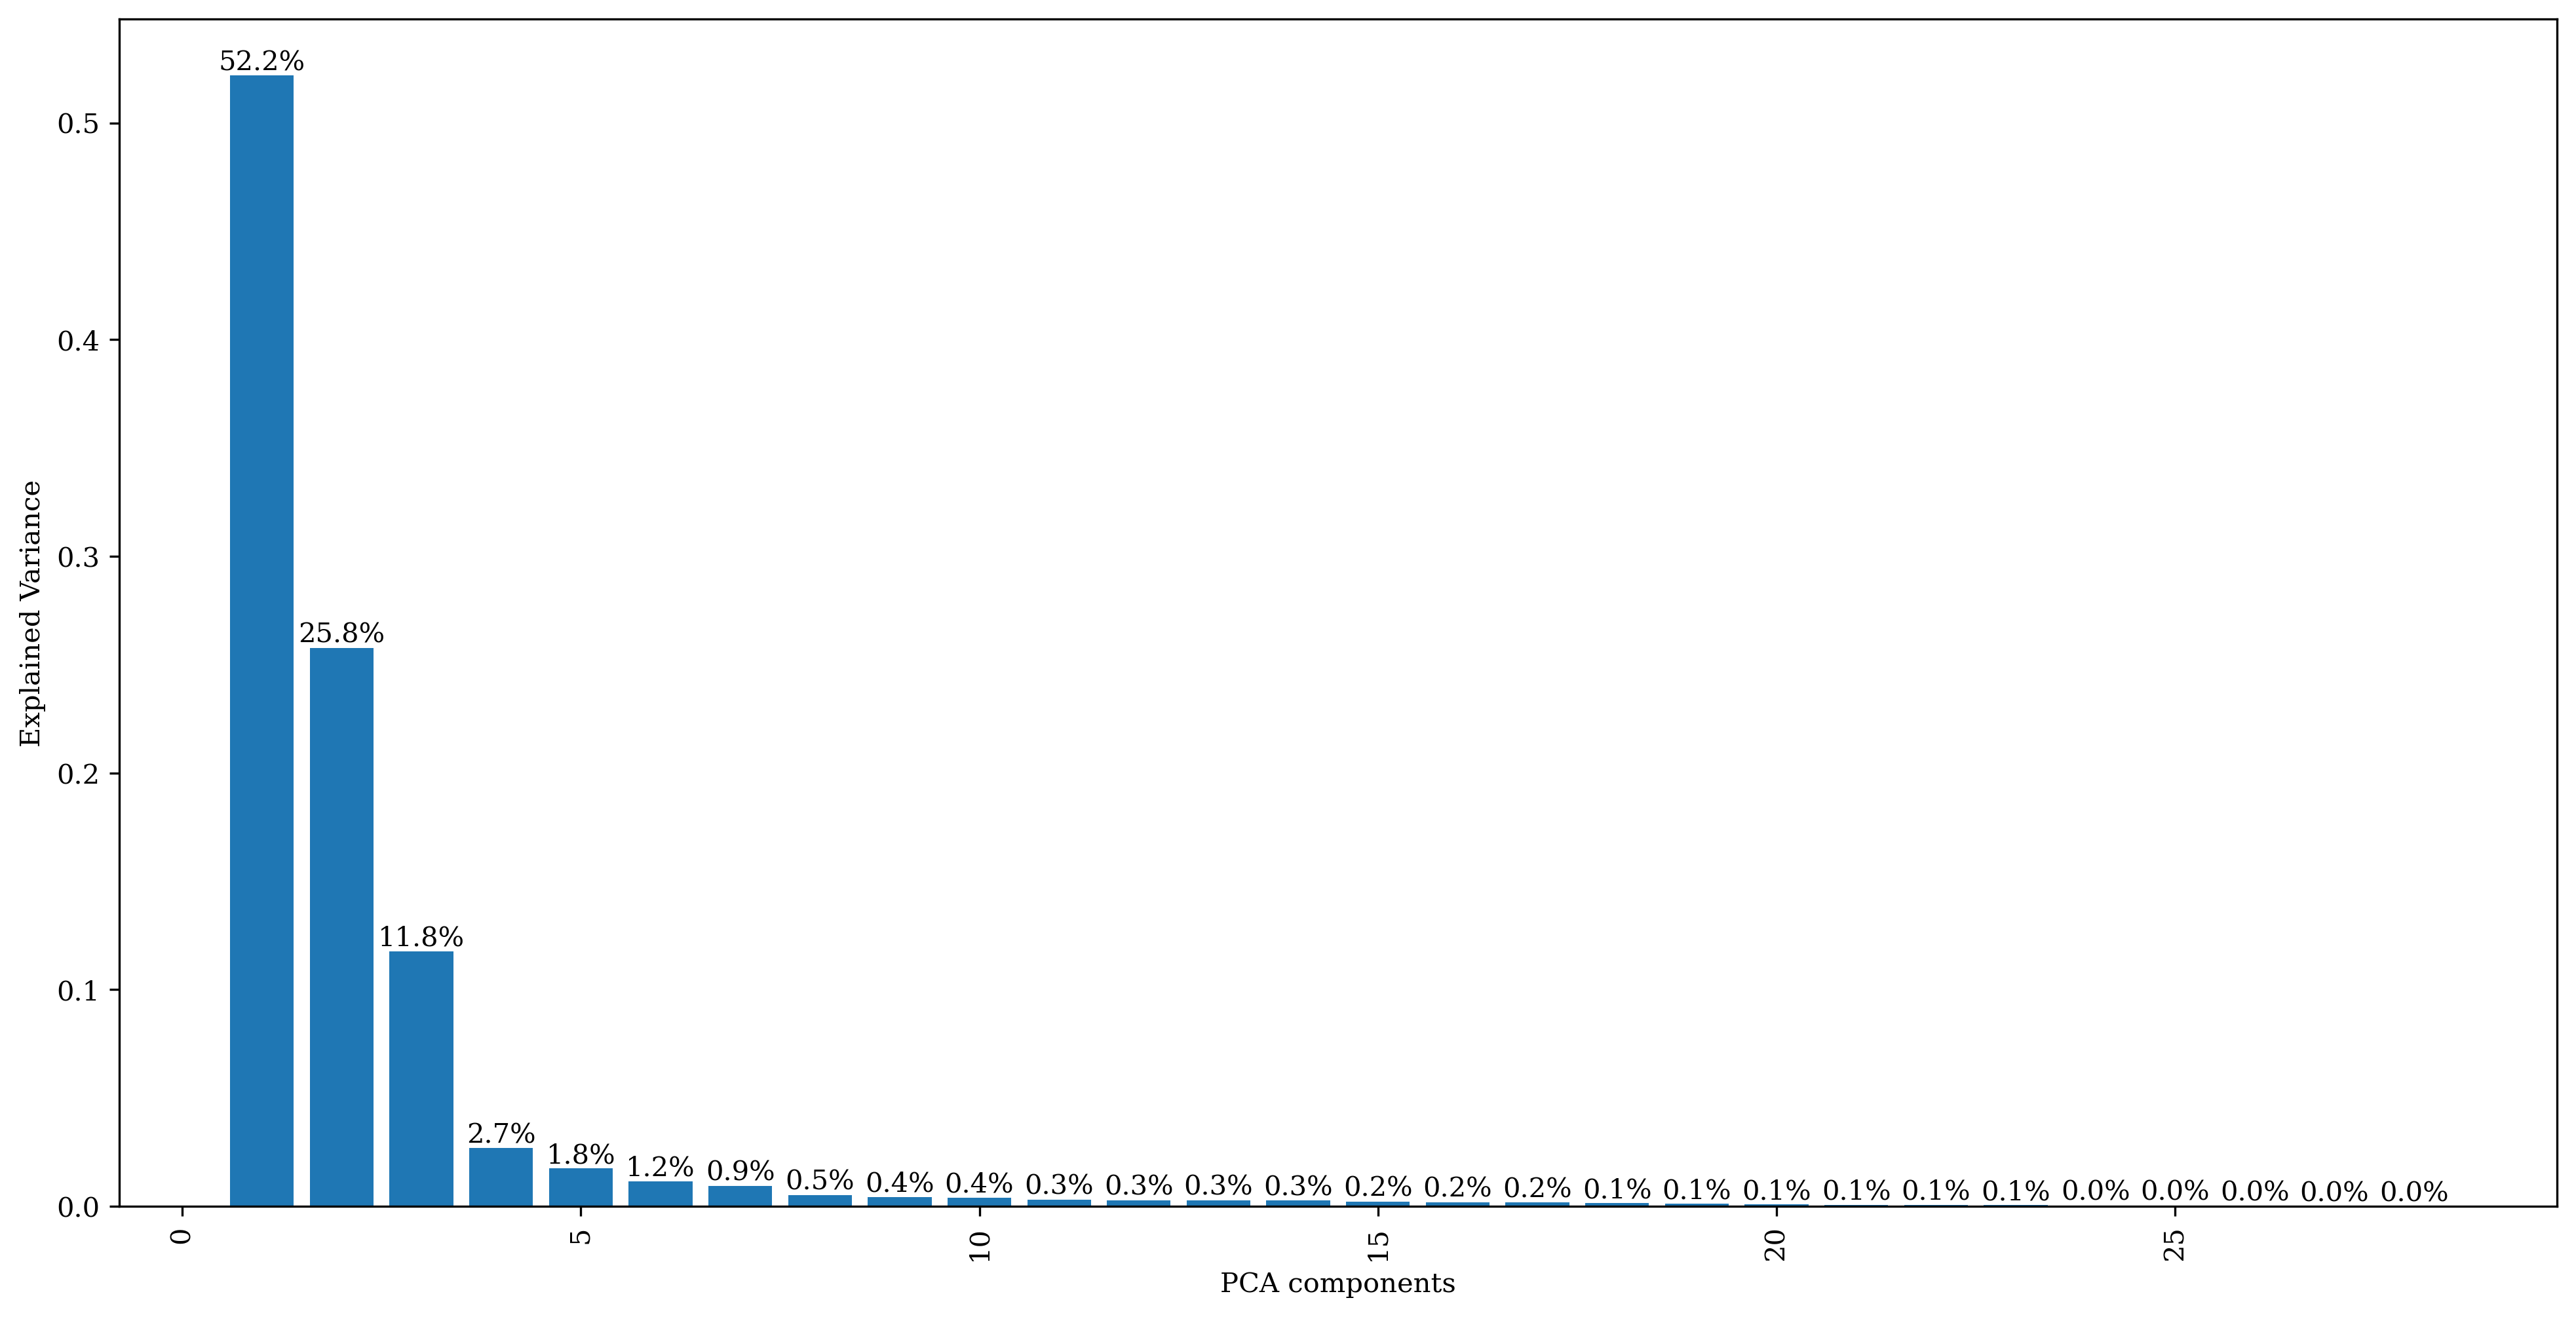

In [9]:
n = 50
plt.figure(figsize=(16, 8))
plt.bar(icomps[:n], vrs[:n])
plt.xticks(rotation = 90)
for icomp, vr in list(zip(icomps, vrs))[:n]:
    plt.annotate(f'{vr:.1%}', xy=(icomp, vr), ha='center', va='bottom')
plt.ylabel('Explained Variance')
plt.xlabel('PCA components')
savefig('pca-explained-variance')

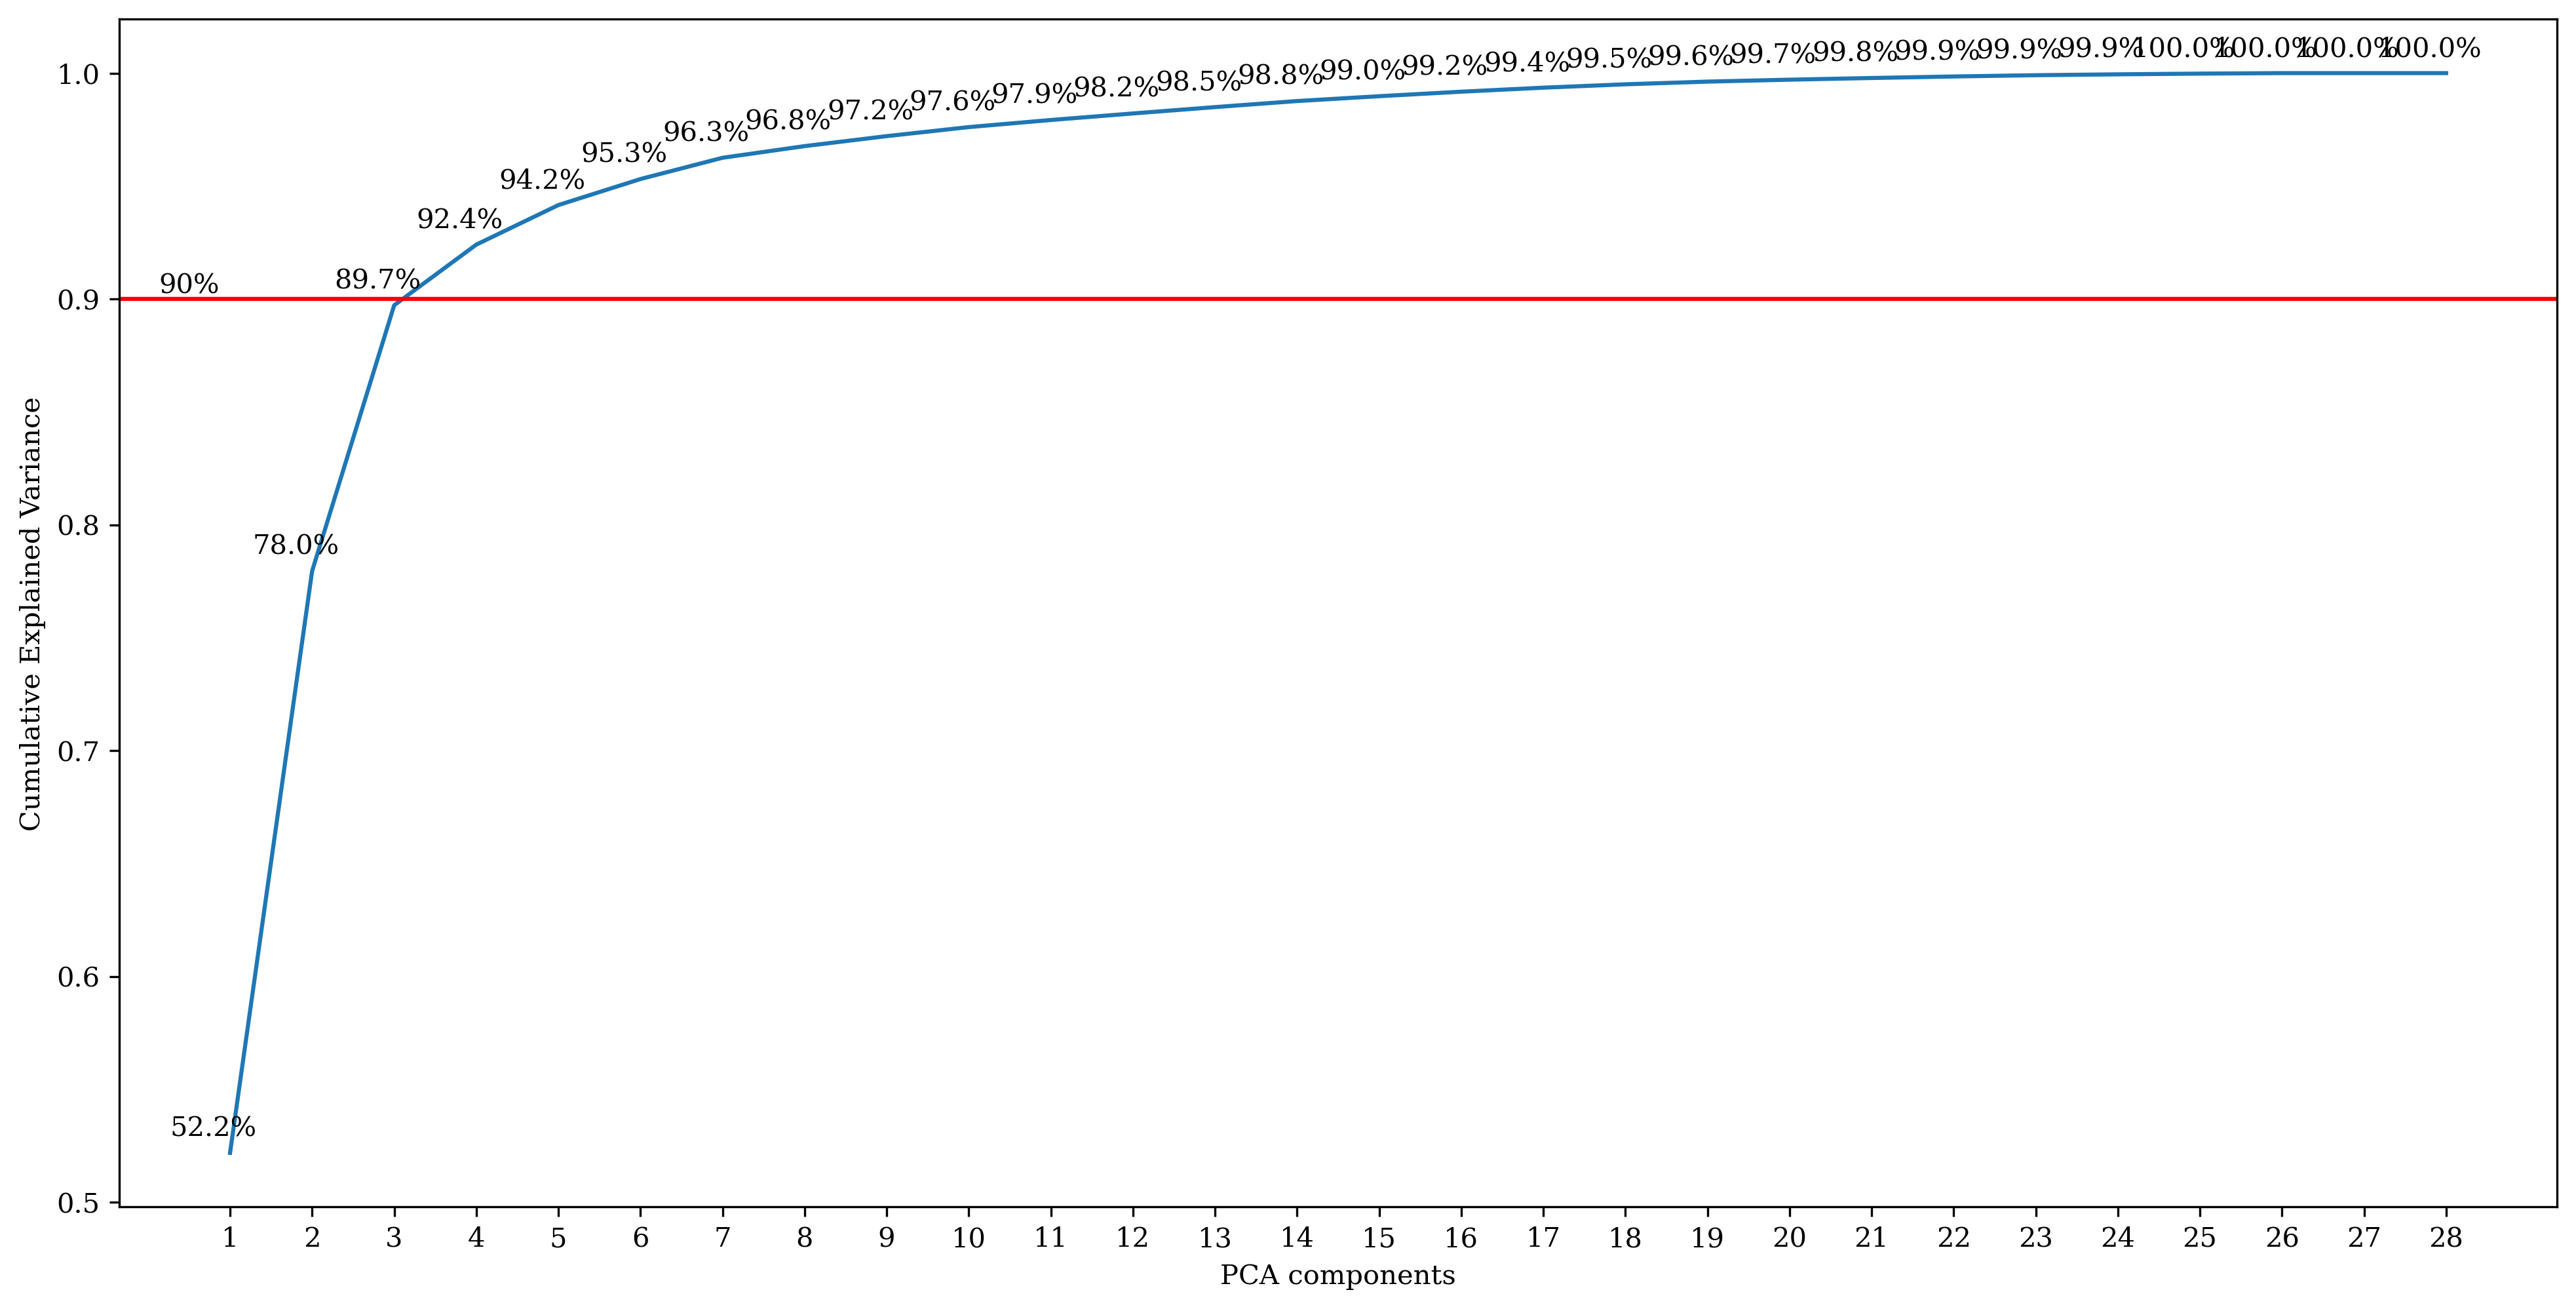

In [10]:
cvrs = np.cumsum(vrs)

plt.figure(figsize=(16, 8))
plt.plot(icomps[:n], cvrs[:n])
plt.xticks(icomps[:n])
for icomp, vr in list(zip(icomps, cvrs))[:n]:
    plt.annotate(f'{vr:.1%}', xy=(icomp-0.2, vr+0.005), ha='center', va='bottom')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.annotate('90%', xy=(0.5, 0.90), ha='center', va='bottom')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('PCA components')
savefig('pca-cumulative-explained-variance')

As it's seen from the figure above, 3 components out of 28 covers 90% of the variance in the data. Hence, we'll reduce all numerical variables into 3 components with PCA dim. reduction.

## Feature selection with Shapley values

Now after appyling dimensionality reduction on numerical featuers, we'll compute Shapley values for the features and then select best performing categorical features.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

def make_preprocessor(x_train: pd.DataFrame):
    numerical_cols = get_numerical_cols(x_train)

    skewness = x_train[numerical_cols].skew()
    sym_numerical_cols = sorted(skewness[skewness.abs() <= 0.5].index.tolist())
    sym_transformer  = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
    ])

    skw_numerical_cols = sorted(list(set(numerical_cols).difference(sym_numerical_cols)))
    skw_transformer  = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', MinMaxScaler()),
    ])

    ordinal_cols = sorted(get_ordinal_cols(x_train))
    ordinal_category_list = [dt.categories.tolist() for dt in x_train[ordinal_cols].dtypes]
    ordinal_transformer = Pipeline([
        ('imputer_pre', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=ordinal_category_list, handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('imputer_post', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ])

    nominal_cols = sorted(get_nominal_cols(x_train))
    nominal_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ])

    n_pca_components = 3

    preprocessor = Pipeline([
        (
            'preprocess', 
            ColumnTransformer([
                ('numerical_sym', sym_transformer, sym_numerical_cols),
                ('numerical_skw', skw_transformer, skw_numerical_cols),
                ('ordinal', ordinal_transformer, ordinal_cols),
                ('nominal', nominal_transformer, nominal_cols),
            ], remainder='drop')
        ),
        (
            'dim_reduction', 
            ColumnTransformer([
                ('pca', PCA(n_components=n_pca_components), list(range(len(sym_numerical_cols + skw_numerical_cols)))),
            ], remainder='passthrough'))
    ]).fit(x_train)

    if nominal_cols:
        nominal_enc_cols = preprocessor.named_steps['preprocess'].transformers_[3][1].named_steps['encoder'].get_feature_names_out(nominal_cols).tolist()
    else:
        nominal_enc_cols = []
    
    preprocessor.feature_names_out_ = [f'pca_out_{i}' for i in range(1, n_pca_components+1)] + ordinal_cols + nominal_enc_cols
    return preprocessor 

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, mean_squared_error

def make_searcher(estimator, param_grid, cv=5, score_averaging = 'weighted', seed=42):
    return GridSearchCV(
        estimator = estimator, 
        param_grid = param_grid,
        scoring = {
            'r2': make_scorer(r2_score), 
            'mse': make_scorer(mean_squared_error),
        }, 
        refit = 'r2',
        cv = cv, # number of folds for cross validation
        verbose=0, 
        n_jobs = 1,
        return_train_score=True,
    )

In [13]:
def fmt_search_results(search):
    sdf = pd.DataFrame(search.cv_results_)
    cols2keep = [col for col in sdf.columns if col=='params' or col.startswith('split')]
    sdf = sdf[cols2keep]
    sdf.columns = pd.MultiIndex.from_tuples([(np.nan, col) if col=='params' else col.split('_', 1) for col in sdf.columns])
    sdf = (sdf.stack(0)
       .ffill()
       .reset_index()
       .drop(columns=['level_0'])
       .dropna(how='any', axis=0)
       .rename(columns={"level_1": "split"})
      )
    
    sdf['estimator_name'] = search.estimator.steps[-1][-1].__class__.__name__
    sdf['estimator'] = search.best_estimator_
    sdf = sdf[['estimator_name', 'params', 'split', 'train_r2', 'test_r2', 'train_mse', 'test_mse', 'estimator']]
    sdf.columns = ['estimator_name', 'params', 'split', 'train_r2', 'val_r2', 'train_mse', 'val_mse', 'estimator']
    return sdf

def average_over_splits(sdf):
    return (sdf
        .assign(params=lambda x: x['params'].apply(str))
        .groupby(['estimator_name', 'params'])
        .agg({
            'train_r2': np.mean,
            'val_r2': np.mean,
            'train_mse': np.mean,
            'val_mse': np.mean,
            'estimator': lambda g: next(iter(g)),
        })
        .sort_values(by='val_r2', ascending=False)
        .reset_index()
    )

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def train_models(x_train, y_train):
    model_param_grids = [
        (
            RandomForestRegressor(max_features='auto'), 
            dict(
                model__min_samples_leaf = [1, 3],
                model__n_estimators = [100, 64, 32],
                model__max_depth= [16, 32, 64],
            )
        ),
        (
            LinearRegression(), 
            dict()
        ),
    ]

    search_result_df = average_over_splits(pd.concat([
        fmt_search_results(
            make_searcher(Pipeline([('preprocessor', make_preprocessor(x_train)), ('model', model)]), pg)
                .fit(x_train, y_train.values.ravel())
        ) 
        for (model, pg) in model_param_grids
    ]))
    return search_result_df

In [15]:
import shap

def compute_shap(model, x):
    explainer = shap.TreeExplainer(model, feature_names=x.columns.tolist(), output_names=TARGETS)
    shap_result = explainer(x)
    shap_result.base_values = shap_result.base_values.ravel()[0]
    return shap_result

def get_feature_importances(shap_result, feature_names):
    feature_importances = np.mean(np.abs(shap_result.values), axis=0)
    return (
        pd.DataFrame({'importance': feature_importances, 'feature': feature_names})
        .assign(variable=lambda dataf: dataf['feature'].apply(lambda col: col.split('_', 1)[0]))
        .groupby('variable')
        .agg({'importance': np.sum})
        .sort_values(by='importance', ascending=False)
    )

In [16]:
search_result_df = train_models(x_train, y_train)
search_result_df[['estimator_name', 'params', 'train_r2', 'val_r2', 'train_mse', 'val_mse']].display(float_format='{:.3f}'.format)

,estimator_name,params,train_r2,val_r2,train_mse,val_mse
0,RandomForestRegressor,"{'model__max_depth': 64, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}",0.964,0.745,0.069,0.485
1,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 1, 'model__n_estimators': 32}",0.961,0.745,0.075,0.486
2,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 3, 'model__n_estimators': 64}",0.919,0.744,0.155,0.487
3,RandomForestRegressor,"{'model__max_depth': 64, 'model__min_samples_leaf': 3, 'model__n_estimators': 100}",0.920,0.744,0.154,0.488
4,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}",0.964,0.744,0.069,0.488
5,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 1, 'model__n_estimators': 64}",0.963,0.744,0.072,0.487
6,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 3, 'model__n_estimators': 100}",0.919,0.744,0.154,0.488
7,RandomForestRegressor,"{'model__max_depth': 16, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}",0.956,0.743,0.083,0.489
8,RandomForestRegressor,"{'model__max_depth': 16, 'model__min_samples_leaf': 3, 'model__n_estimators': 100}",0.918,0.742,0.158,0.491
9,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 3, 'model__n_estimators': 32}",0.917,0.741,0.159,0.493


In [17]:
best_estimator = search_result_df.iloc[0]['estimator']
lin_reg_estimator = search_result_df[search_result_df['estimator_name']=='LinearRegression'].iloc[0]['estimator']

score_comp_df = pd.DataFrame(
    data=[
        (estimator_name, split_name, metric_name, metric(estimator.predict(x), y.values.ravel()))
        for estimator_name, estimator in [('Random Forest Regressor', best_estimator), ('Linear Regressor', lin_reg_estimator)]
        for split_name, x, y in [('Train', x_train, y_train), ('Test', x_test, y_test)]
        for metric_name, metric in [('R2 (higher is better)', r2_score), ('MSE (lower is better)', mean_squared_error)]
    ],
    columns=['Model', 'Set', 'Metric',  'Score']
)
score_comp_df.display(float_format='{:.3f}'.format)

,Model,Set,Metric,Score
0,Random Forest Regressor,Train,R2 (higher is better),0.958
1,Random Forest Regressor,Train,MSE (lower is better),0.067
2,Random Forest Regressor,Test,R2 (higher is better),0.656
3,Random Forest Regressor,Test,MSE (lower is better),0.515
4,Linear Regressor,Train,R2 (higher is better),0.766
5,Linear Regressor,Train,MSE (lower is better),0.362
6,Linear Regressor,Test,R2 (higher is better),-0.001
7,Linear Regressor,Test,MSE (lower is better),394140401650427328.000


In [18]:
preprocessor = make_preprocessor(x_train)
model = best_estimator.named_steps['model']

x_train_proc = pd.DataFrame(preprocessor.transform(x_train), columns=preprocessor.feature_names_out_) 
y_train_proc = y_train.values.ravel()

shap_result = compute_shap(model, x_train_proc)
feature_importance_df = get_feature_importances(shap_result, preprocessor.feature_names_out_).drop(index=['pca'])

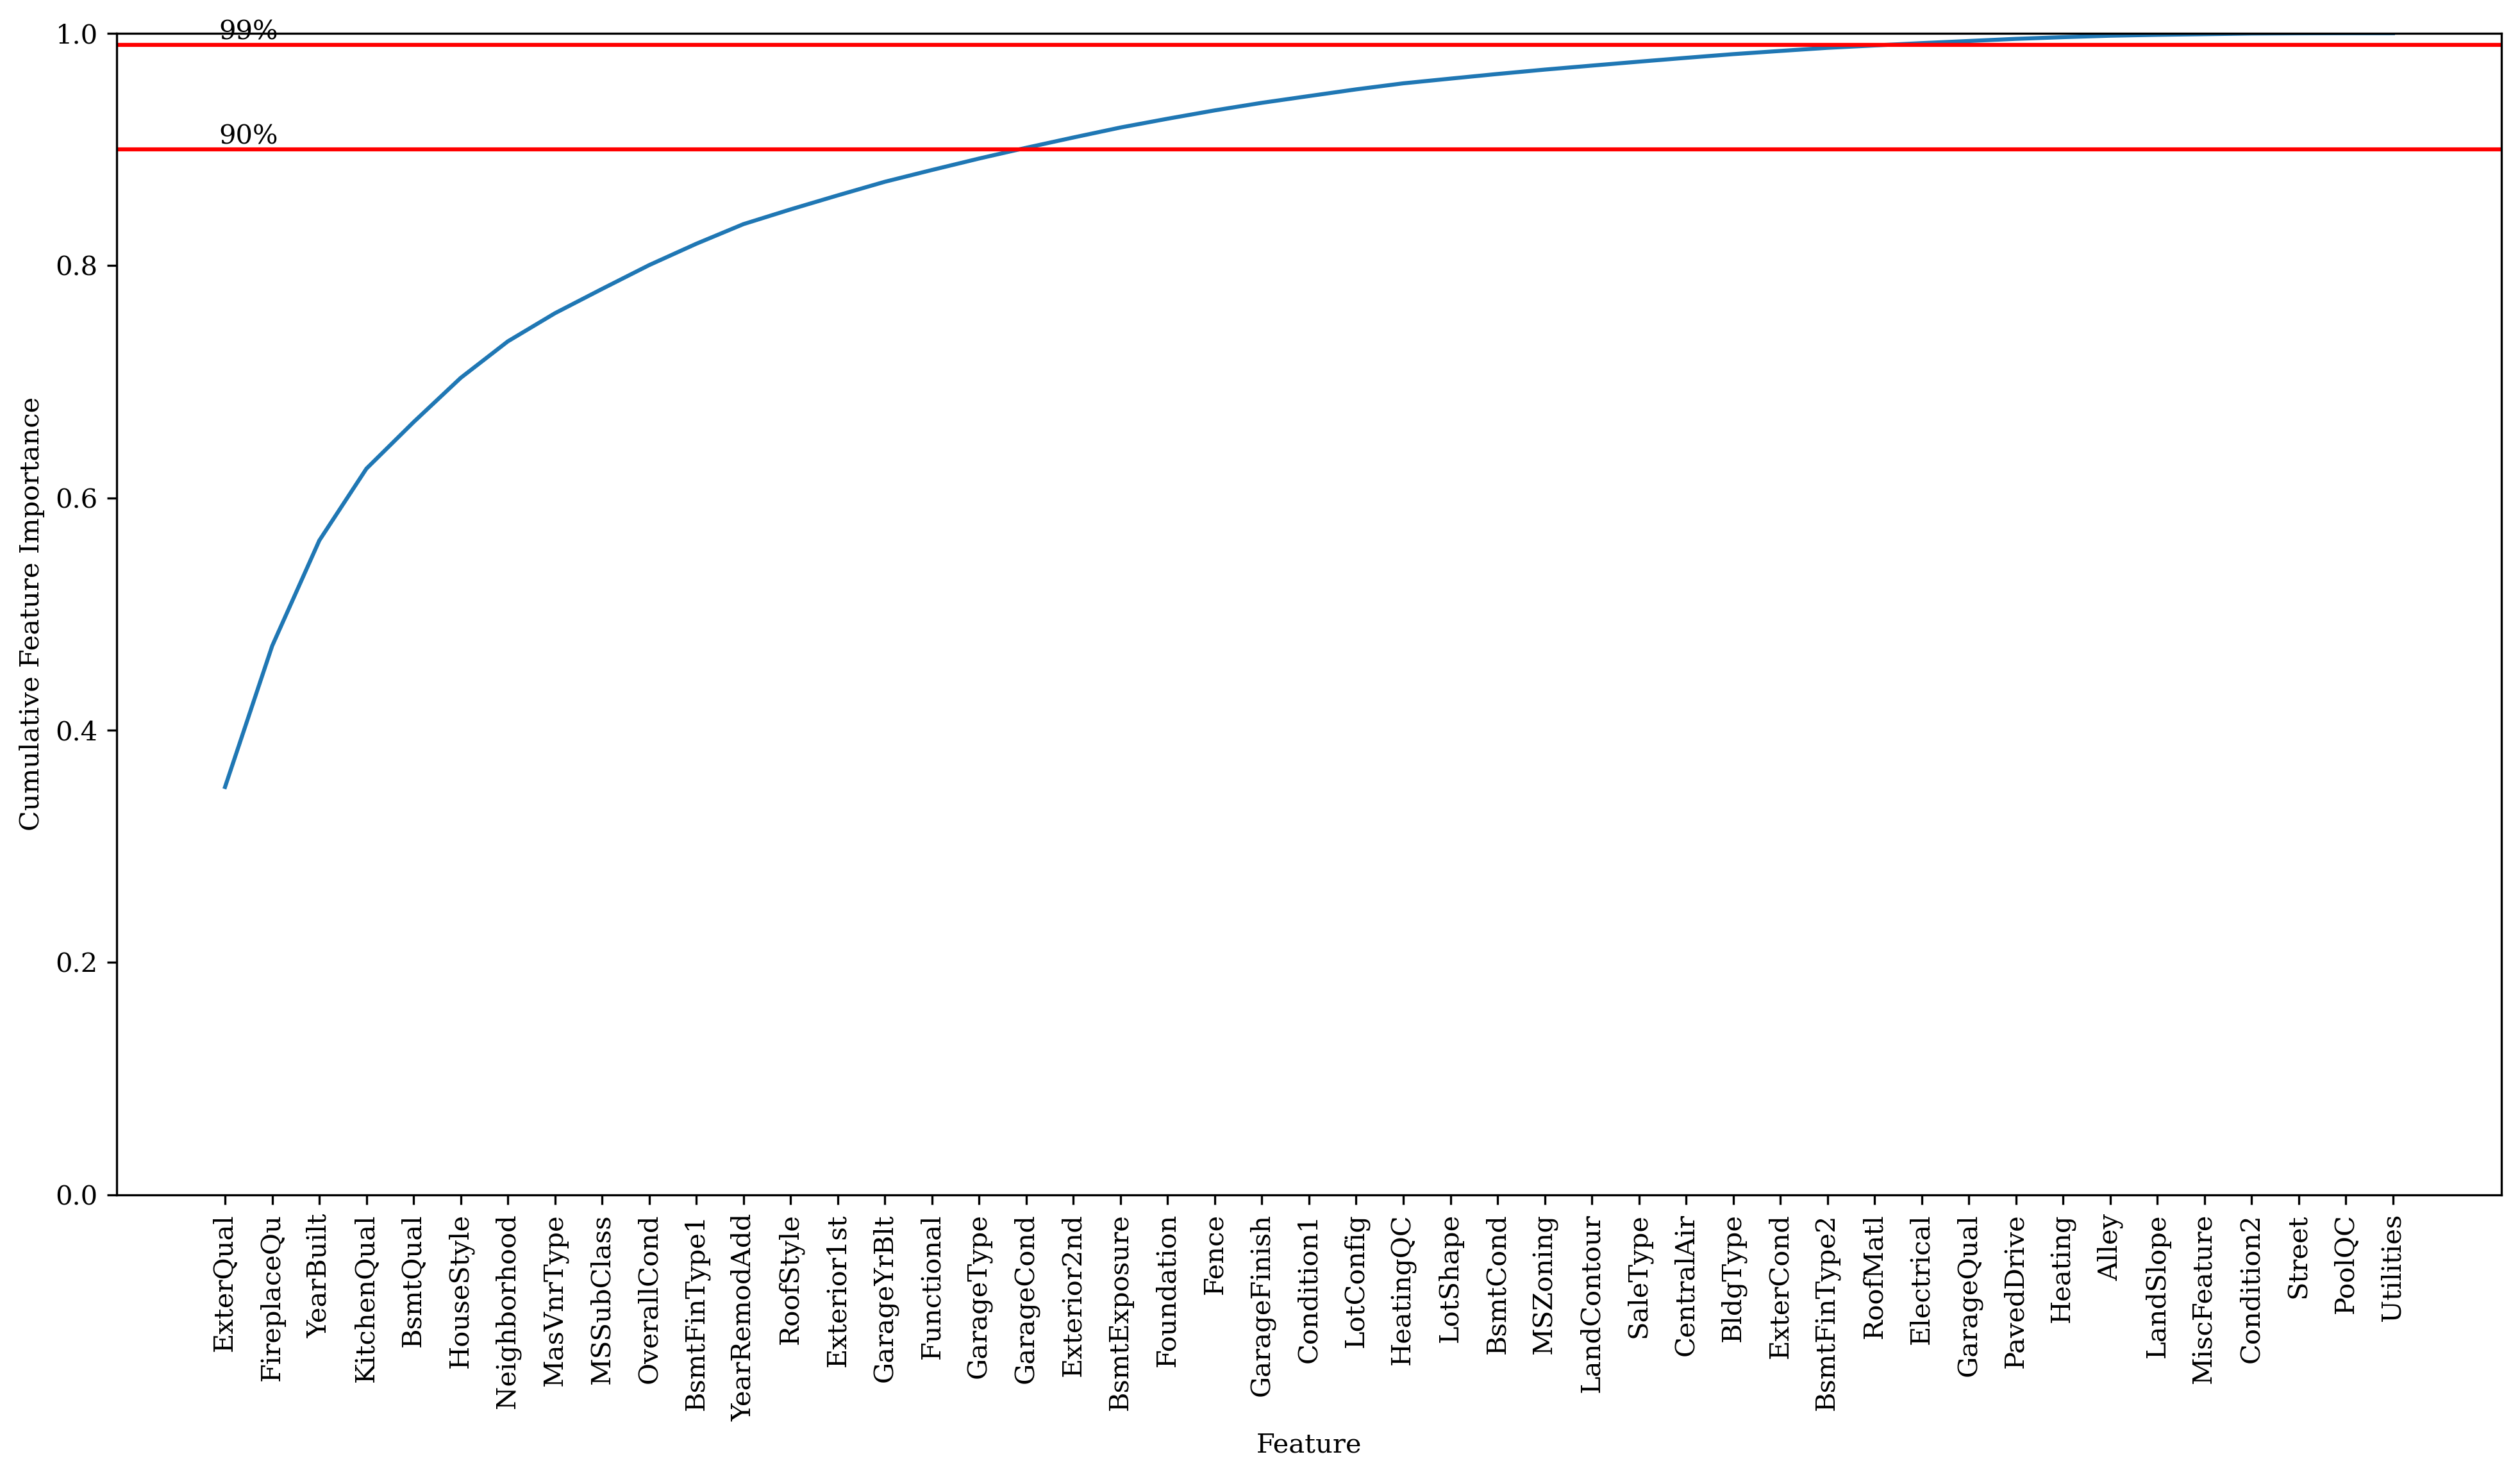

In [19]:
fidf = feature_importance_df.assign(importance=lambda dataf: dataf['importance']/dataf['importance'].sum())
icomps = range(1, len(fidf)+1)
cum_contribs = np.cumsum(fidf['importance'].values)

plt.figure(figsize=(16, 8))
plt.plot(fidf.index.values, cum_contribs)
plt.xticks(rotation=90)
plt.ylabel('Cumulative Feature Importance')
plt.xlabel('Feature')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.annotate('90%', xy=(0.5, 0.90), ha='center', va='bottom')
plt.axhline(y=0.99, color='r', linestyle='-')
plt.annotate('99%', xy=(0.5, 0.99), ha='center', va='bottom')
plt.ylim([0,1])
savefig('shap-cumulative-feature-importance')

In [20]:
best_categorical_variables = fidf.index.values[:17]

x_train_pre = x_train
x_train = x_train.drop(columns=set(ORDINALS+NOMINALS).difference(best_categorical_variables), errors='ignore')

x_test_pre = x_test
x_test = x_test.drop(columns=set(ORDINALS+NOMINALS).difference(best_categorical_variables), errors='ignore')

## Training

We'll train models with this new dataset after dimensionality reduction and feature selection.

In [21]:
search_result_df = train_models(x_train, y_train)

In [22]:
search_result_df[['estimator_name', 'params', 'train_r2', 'val_r2', 'train_mse', 'val_mse']].display()

,estimator_name,params,train_r2,val_r2,train_mse,val_mse
0,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}",0.963293,0.742973,0.070144,0.489307
1,RandomForestRegressor,"{'model__max_depth': 64, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}",0.962950,0.742029,0.070791,0.491564
2,RandomForestRegressor,"{'model__max_depth': 16, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}",0.956792,0.741022,0.082572,0.492985
3,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 3, 'model__n_estimators': 64}",0.913562,0.740600,0.165185,0.494016
4,RandomForestRegressor,"{'model__max_depth': 16, 'model__min_samples_leaf': 3, 'model__n_estimators': 100}",0.913119,0.740512,0.166044,0.493891
5,RandomForestRegressor,"{'model__max_depth': 16, 'model__min_samples_leaf': 3, 'model__n_estimators': 64}",0.912188,0.740394,0.167796,0.494409
6,RandomForestRegressor,"{'model__max_depth': 64, 'model__min_samples_leaf': 3, 'model__n_estimators': 100}",0.914116,0.739804,0.164133,0.495358
7,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 1, 'model__n_estimators': 64}",0.962804,0.738963,0.071081,0.497008
8,RandomForestRegressor,"{'model__max_depth': 32, 'model__min_samples_leaf': 3, 'model__n_estimators': 100}",0.914395,0.738892,0.163573,0.497107
9,RandomForestRegressor,"{'model__max_depth': 64, 'model__min_samples_leaf': 1, 'model__n_estimators': 32}",0.960156,0.738875,0.076100,0.496759


In [23]:
best_estimator = search_result_df.iloc[0]['estimator']
lin_reg_estimator = search_result_df[search_result_df['estimator_name']=='LinearRegression'].iloc[0]['estimator']


In [24]:
preprocessor = make_preprocessor(x_train)
model = best_estimator.named_steps['model']

x_test_proc = pd.DataFrame(preprocessor.transform(x_test), columns=preprocessor.feature_names_out_) 
y_test_proc = y_test.values.ravel() 

y_test_pred = model.predict(x_test_proc.values)

shap_result = compute_shap(model, x_test_proc)

## Evalutation

We'll apply 5x2cv paired t-test from `mlextend` library to check whether the best estimator 
is significantly better from the baseline. If the p value is lower than $\alpha=0.1$, 
then we can reject the null hypothesis that the two models perform same.

In [25]:
# From mlextend library
# https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/ttest.py

import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import get_scorer

def paired_ttest_5x2cv(estimator1, estimator2, X, y,
                       scoring=None,
                       random_seed=None):
    """
    Implements the 5x2cv paired t test proposed
    by Dieterrich (1998)
    to compare the performance of two models.
    Parameters
    ----------
    estimator1 : scikit-learn classifier or regressor
    estimator2 : scikit-learn classifier or regressor
    X : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape = [n_samples]
        Target values.
    scoring : str, callable, or None (default: None)
        If None (default), uses 'accuracy' for sklearn classifiers
        and 'r2' for sklearn regressors.
        If str, uses a sklearn scoring metric string identifier, for example
        {accuracy, f1, precision, recall, roc_auc} for classifiers,
        {'mean_absolute_error', 'mean_squared_error'/'neg_mean_squared_error',
        'median_absolute_error', 'r2'} for regressors.
        If a callable object or function is provided, it has to be conform with
        sklearn's signature ``scorer(estimator, X, y)``; see
        http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
        for more information.
    random_seed : int or None (default: None)
        Random seed for creating the test/train splits.
    Returns
    ----------
    t : float
        The t-statistic
    pvalue : float
        Two-tailed p-value.
        If the chosen significance level is larger
        than the p-value, we reject the null hypothesis
        and accept that there are significant differences
        in the two compared models.
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
    """
    rng = np.random.RandomState(random_seed)

    if scoring is None:
        if estimator1._estimator_type == 'classifier':
            scoring = 'accuracy'
        elif estimator1._estimator_type == 'regressor':
            scoring = 'r2'
        else:
            raise AttributeError('Estimator must '
                                 'be a Classifier or Regressor.')
    if isinstance(scoring, str):
        scorer = get_scorer(scoring)
    else:
        scorer = scoring

    variance_sum = 0.
    first_diff = None

    def score_diff(X_1, X_2, y_1, y_2):

        estimator1.fit(X_1, y_1)
        estimator2.fit(X_1, y_1)
        est1_score = scorer(estimator1, X_2, y_2)
        est2_score = scorer(estimator2, X_2, y_2)
        score_diff = est1_score - est2_score
        return score_diff

    for i in range(5):

        randint = rng.randint(low=0, high=32767)
        X_1, X_2, y_1, y_2 = \
            train_test_split(X, y, test_size=0.5,
                             random_state=randint)

        score_diff_1 = score_diff(X_1, X_2, y_1, y_2)
        score_diff_2 = score_diff(X_2, X_1, y_2, y_1)
        score_mean = (score_diff_1 + score_diff_2) / 2.
        score_var = ((score_diff_1 - score_mean)**2 +
                     (score_diff_2 - score_mean)**2)
        variance_sum += score_var
        if first_diff is None:
            first_diff = score_diff_1

    numerator = first_diff
    denominator = np.sqrt(1/5. * variance_sum)
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), 5)*2.
    return float(t_stat), float(pvalue)

In [26]:
_, pvalue = paired_ttest_5x2cv(
    estimator1=best_estimator,
    estimator2=lin_reg_estimator,
    X=x_train.copy(), 
    y=y_train.copy().values.ravel(),
    random_seed=42
)
print(f'p-value: {pvalue:.3f}')

p-value: 0.949


Since the p-value is not lower than $\alpha=0.1$, we cannot conclude that the best estimator is significantly better than the baseline.

In [27]:
score_comp_df = pd.DataFrame(
    data=[
        (estimator_name, split_name, metric_name, metric(estimator.predict(x), y.values.ravel()))
        for estimator_name, estimator in [('Random Forest Regressor', best_estimator), ('Linear Regressor', lin_reg_estimator)]
        for split_name, x, y in [('Test', x_test, y_test)]
        for metric_name, metric in [('R2', r2_score), ('MSE', mean_squared_error)]
    ],
    columns=['Model', 'Set', 'Metric',  'Score']
)
score_comp_df.display()

,Model,Set,Metric,Score
0,Random Forest Regressor,Test,R2,0.612693
1,Random Forest Regressor,Test,MSE,0.566384
2,Linear Regressor,Test,R2,0.649614
3,Linear Regressor,Test,MSE,0.553640


## Model interpretation with Shapley values

Let's take a look at SHAP values for a sample with 10 `OverallQual`.

Ground Truth: 10.00
Prediction  : 9.22


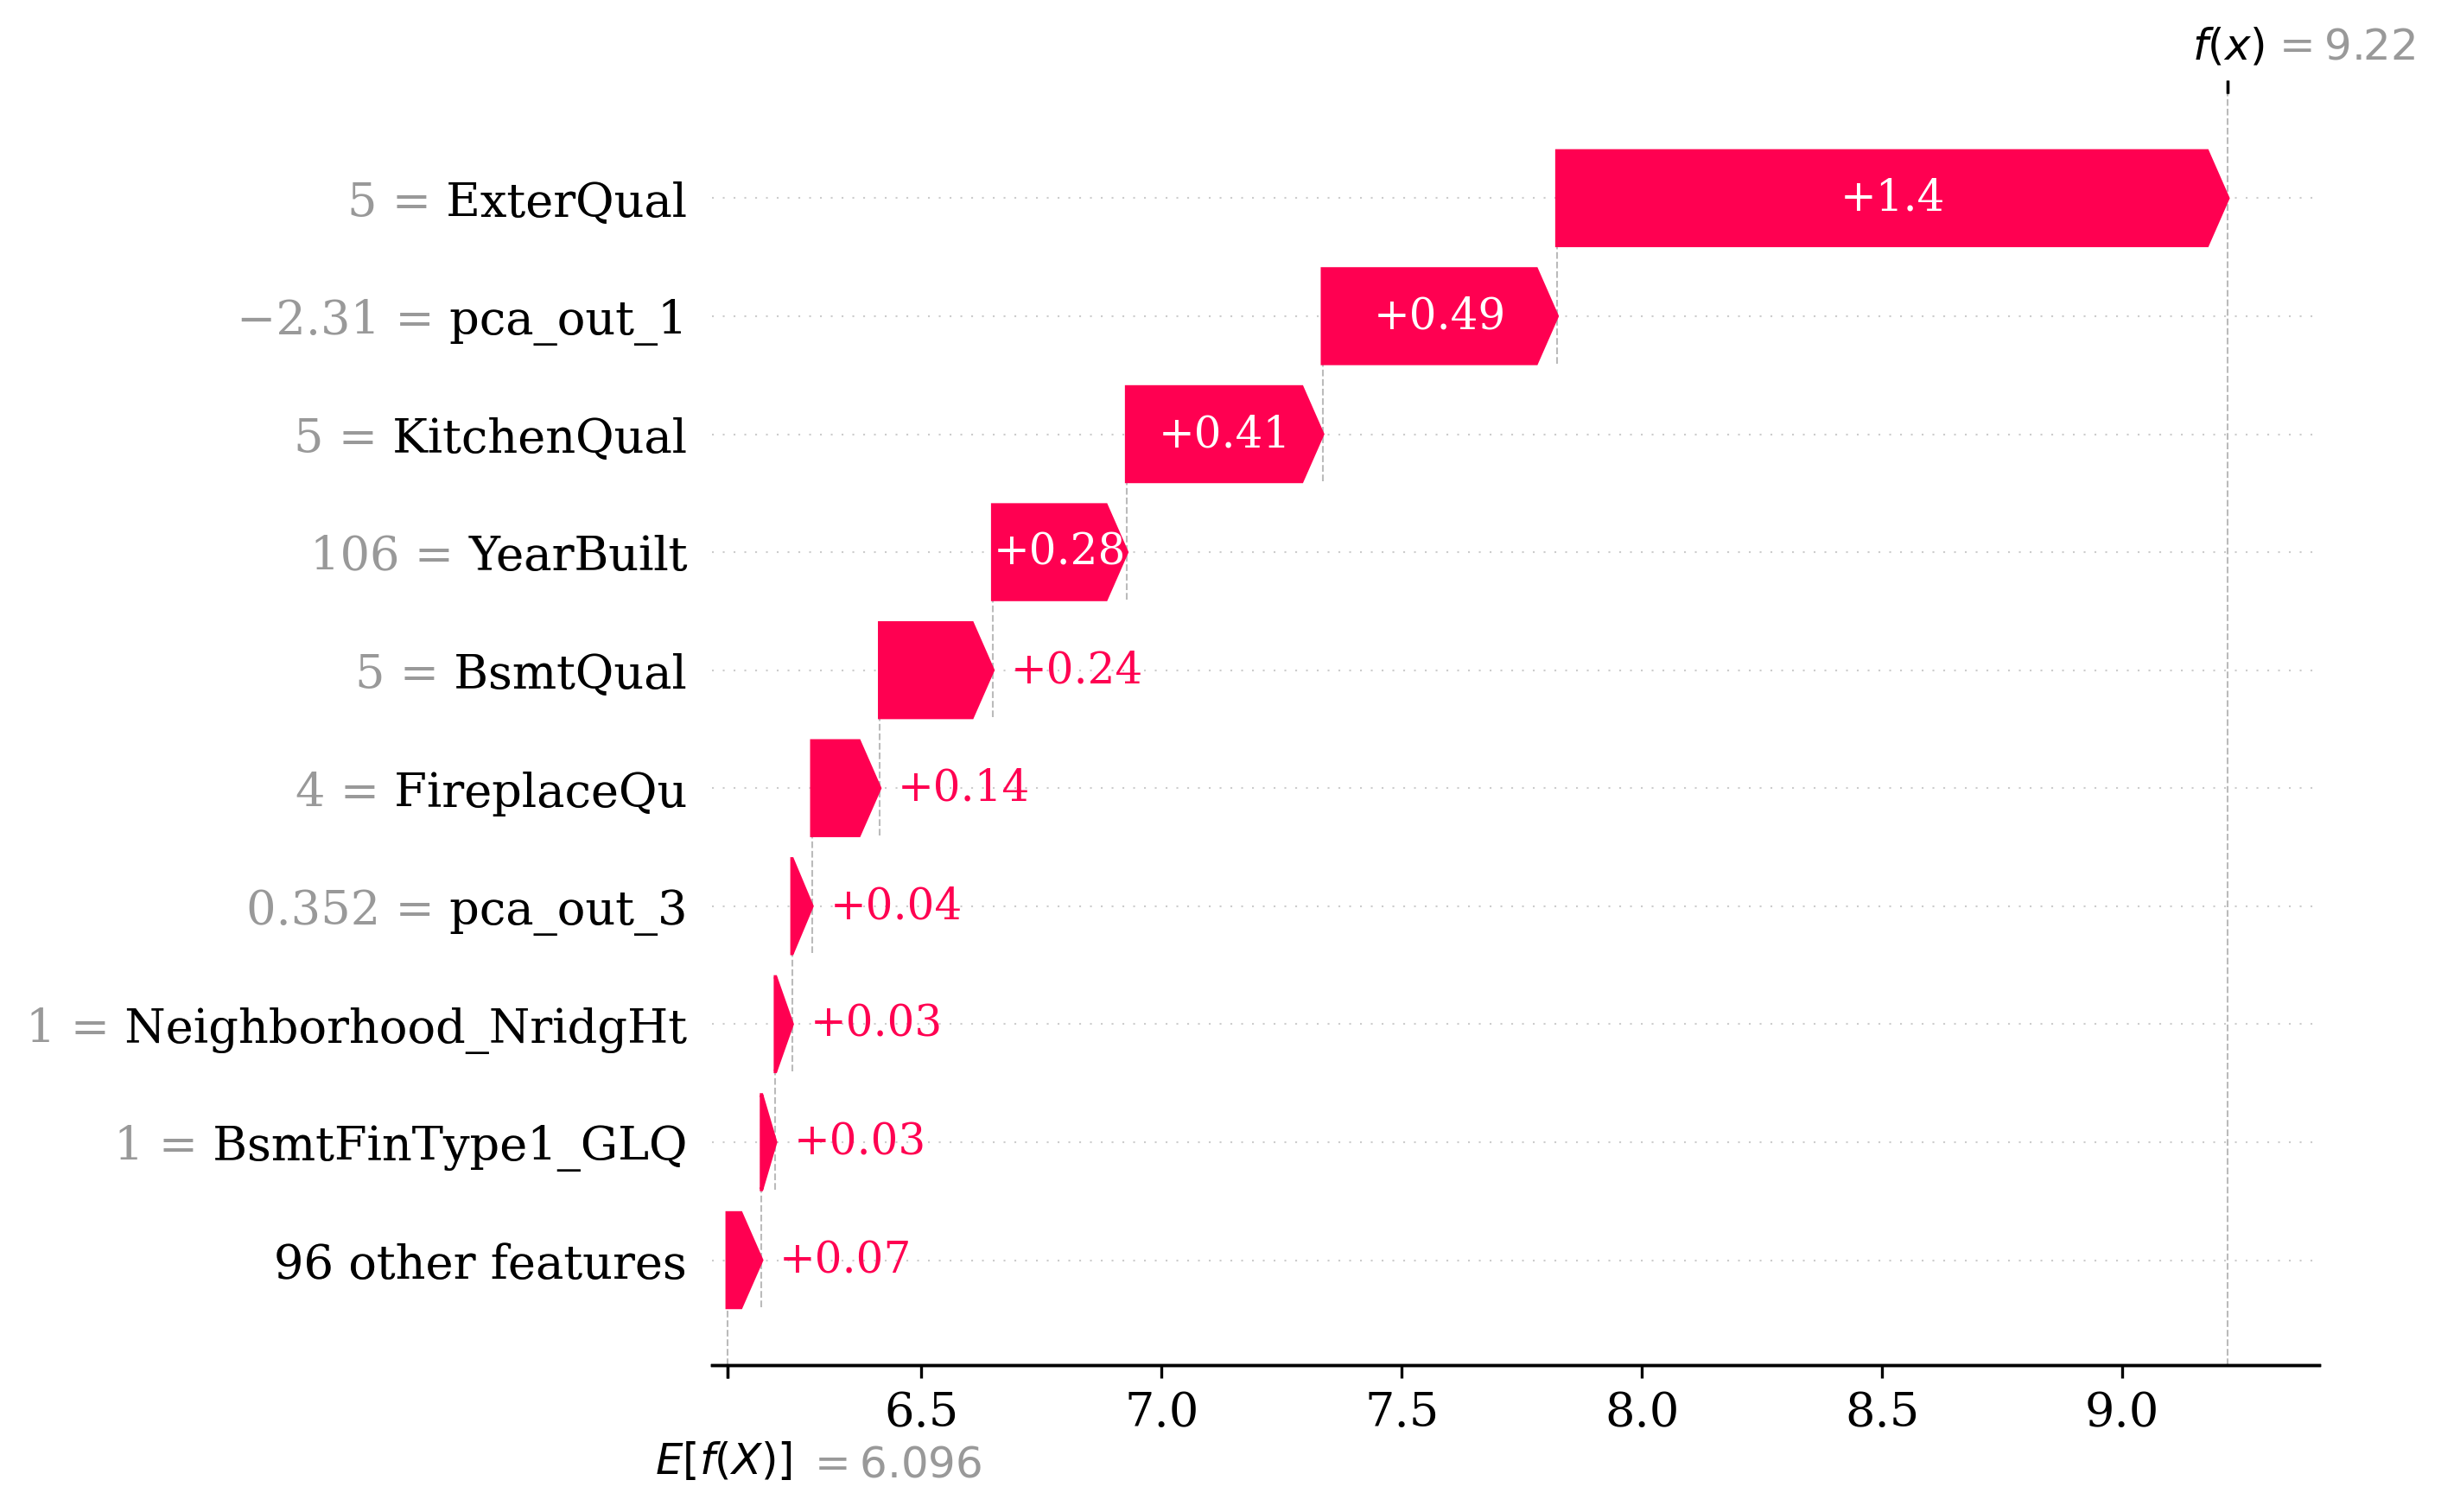

In [28]:
idx = np.random.choice(np.where(y_test_proc==10)[0])
print(f'Ground Truth: {y_test_proc[idx]:.2f}')
print(f'Prediction  : {y_test_pred[idx]:.2f}')
shap.plots.waterfall(shap_result[idx])

And a sample with 3 `OverallQual`.

Ground Truth: 3.00
Prediction  : 4.22


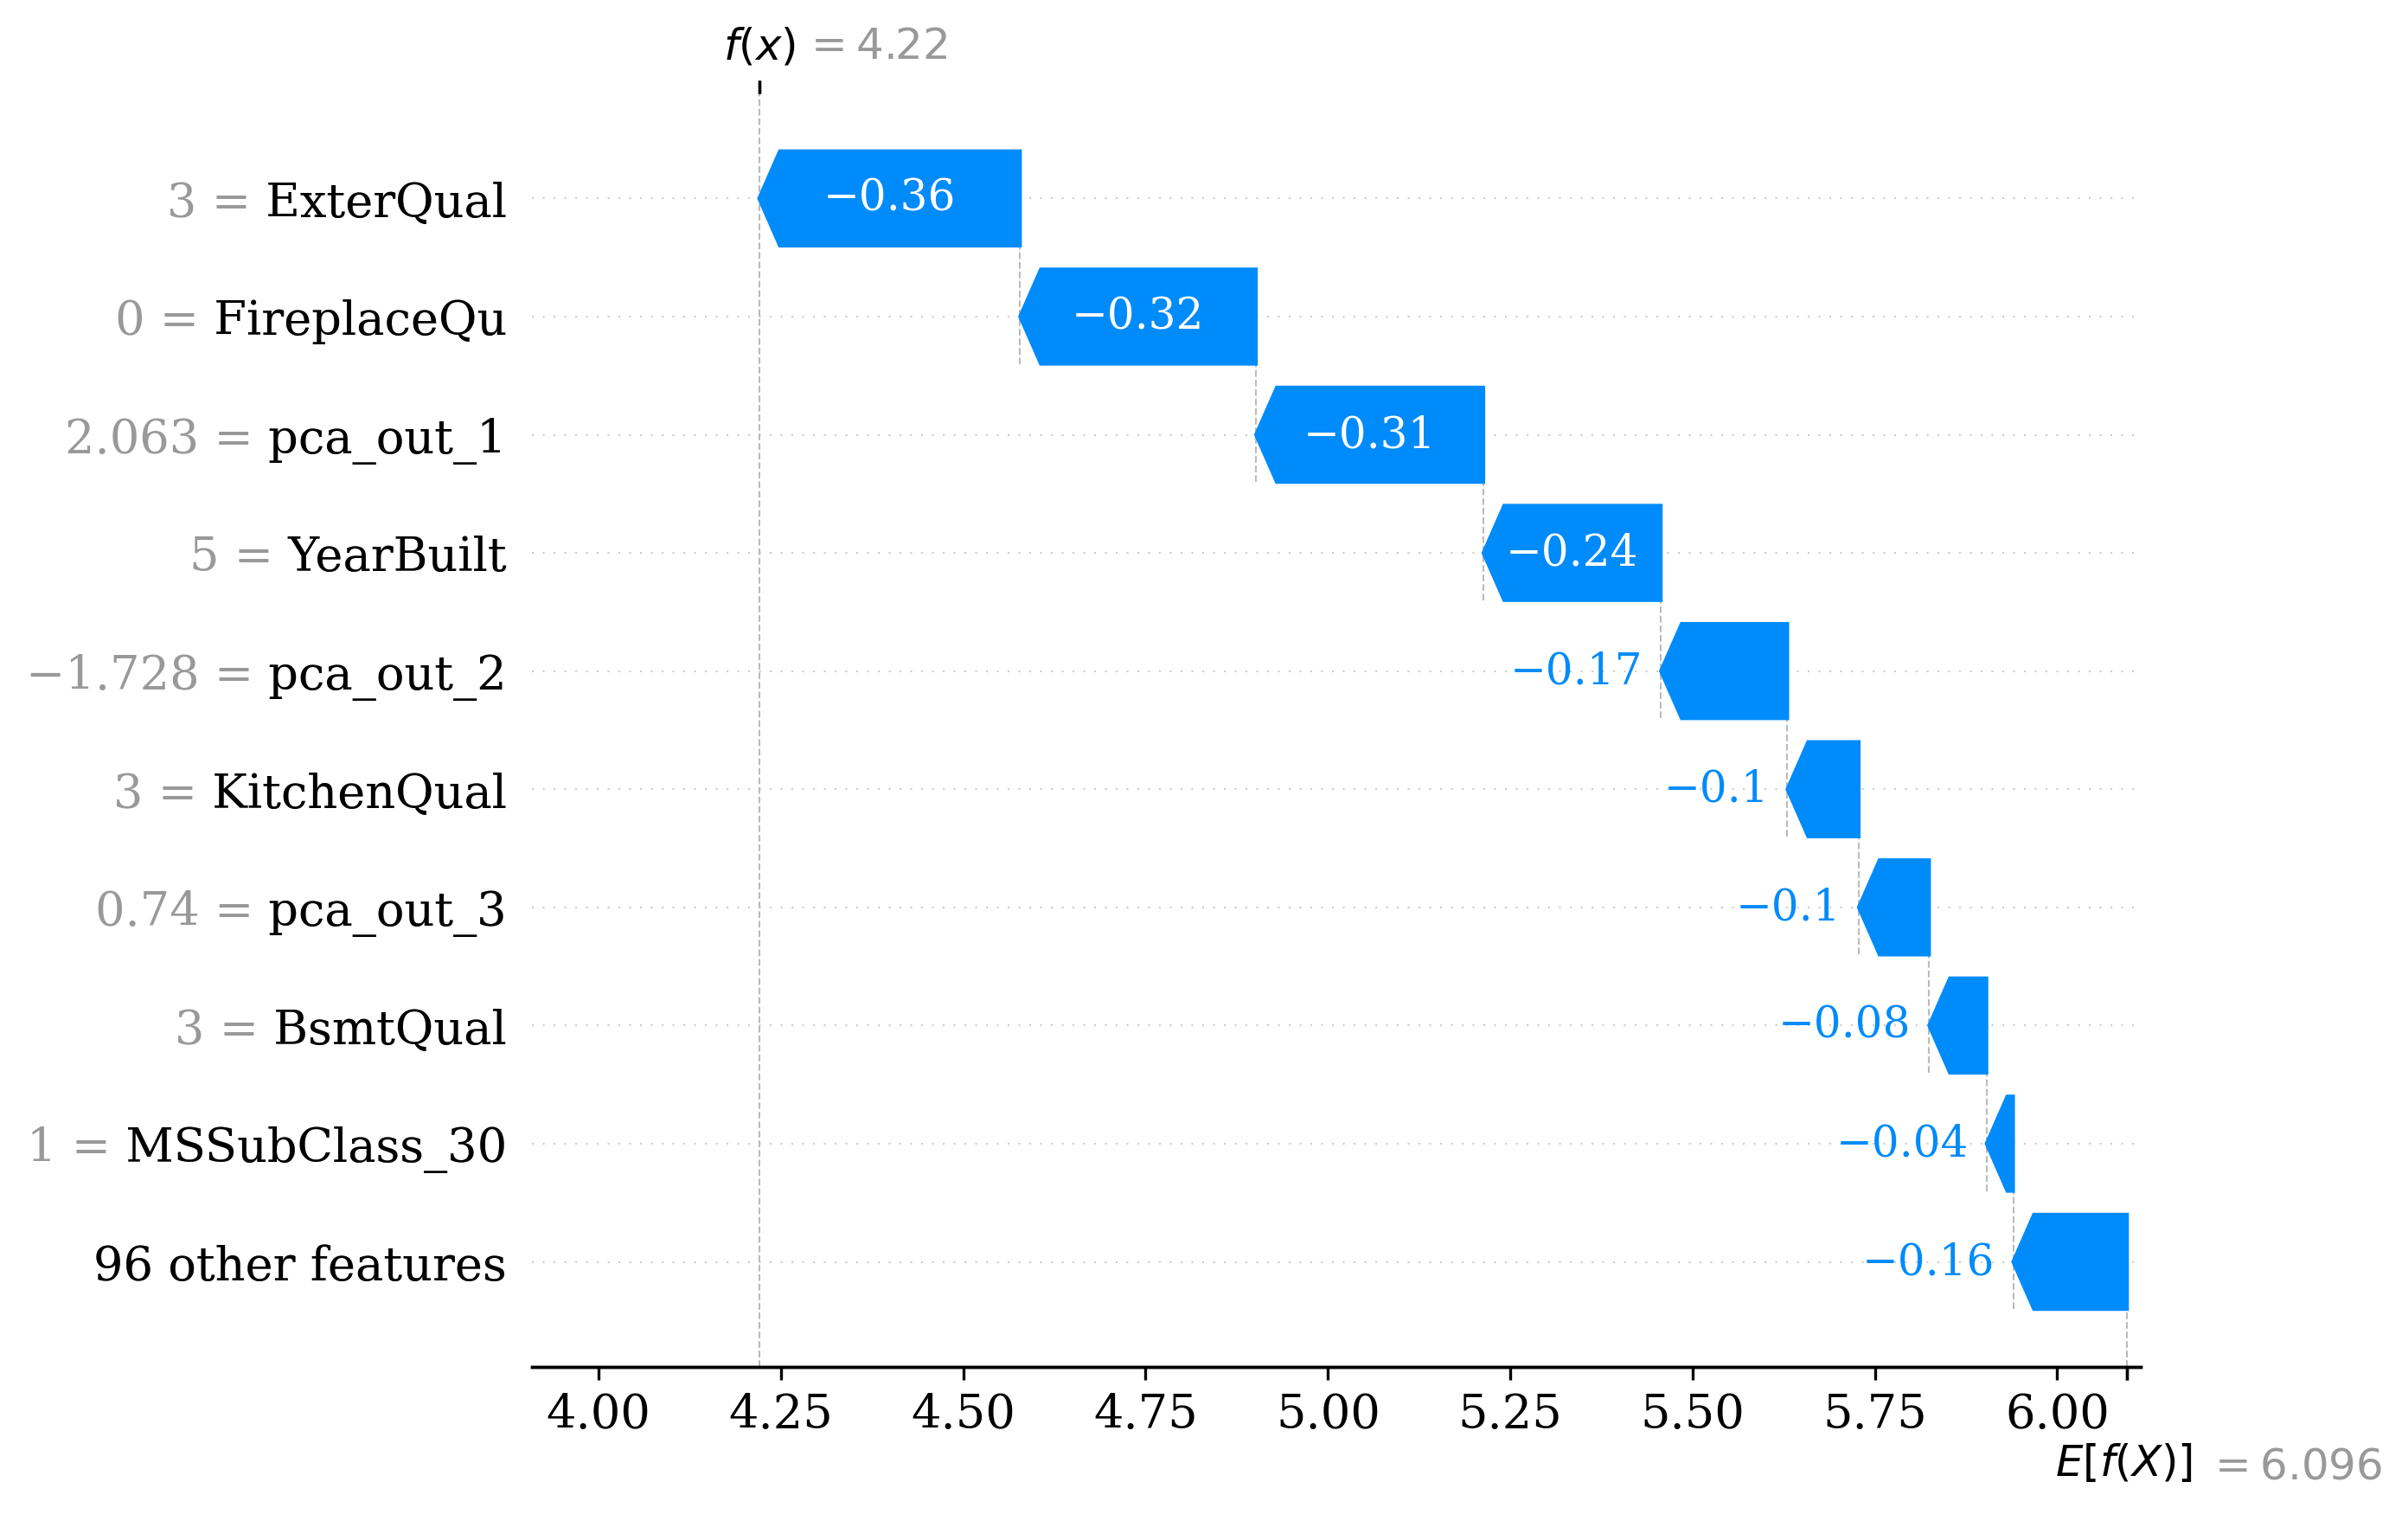

In [29]:
idx = np.random.choice(np.where(y_test_proc==3)[0])

print(f'Ground Truth: {y_test_proc[idx]:.2f}')
print(f'Prediction  : {y_test_pred[idx]:.2f}')
shap.plots.waterfall(shap_result[idx])

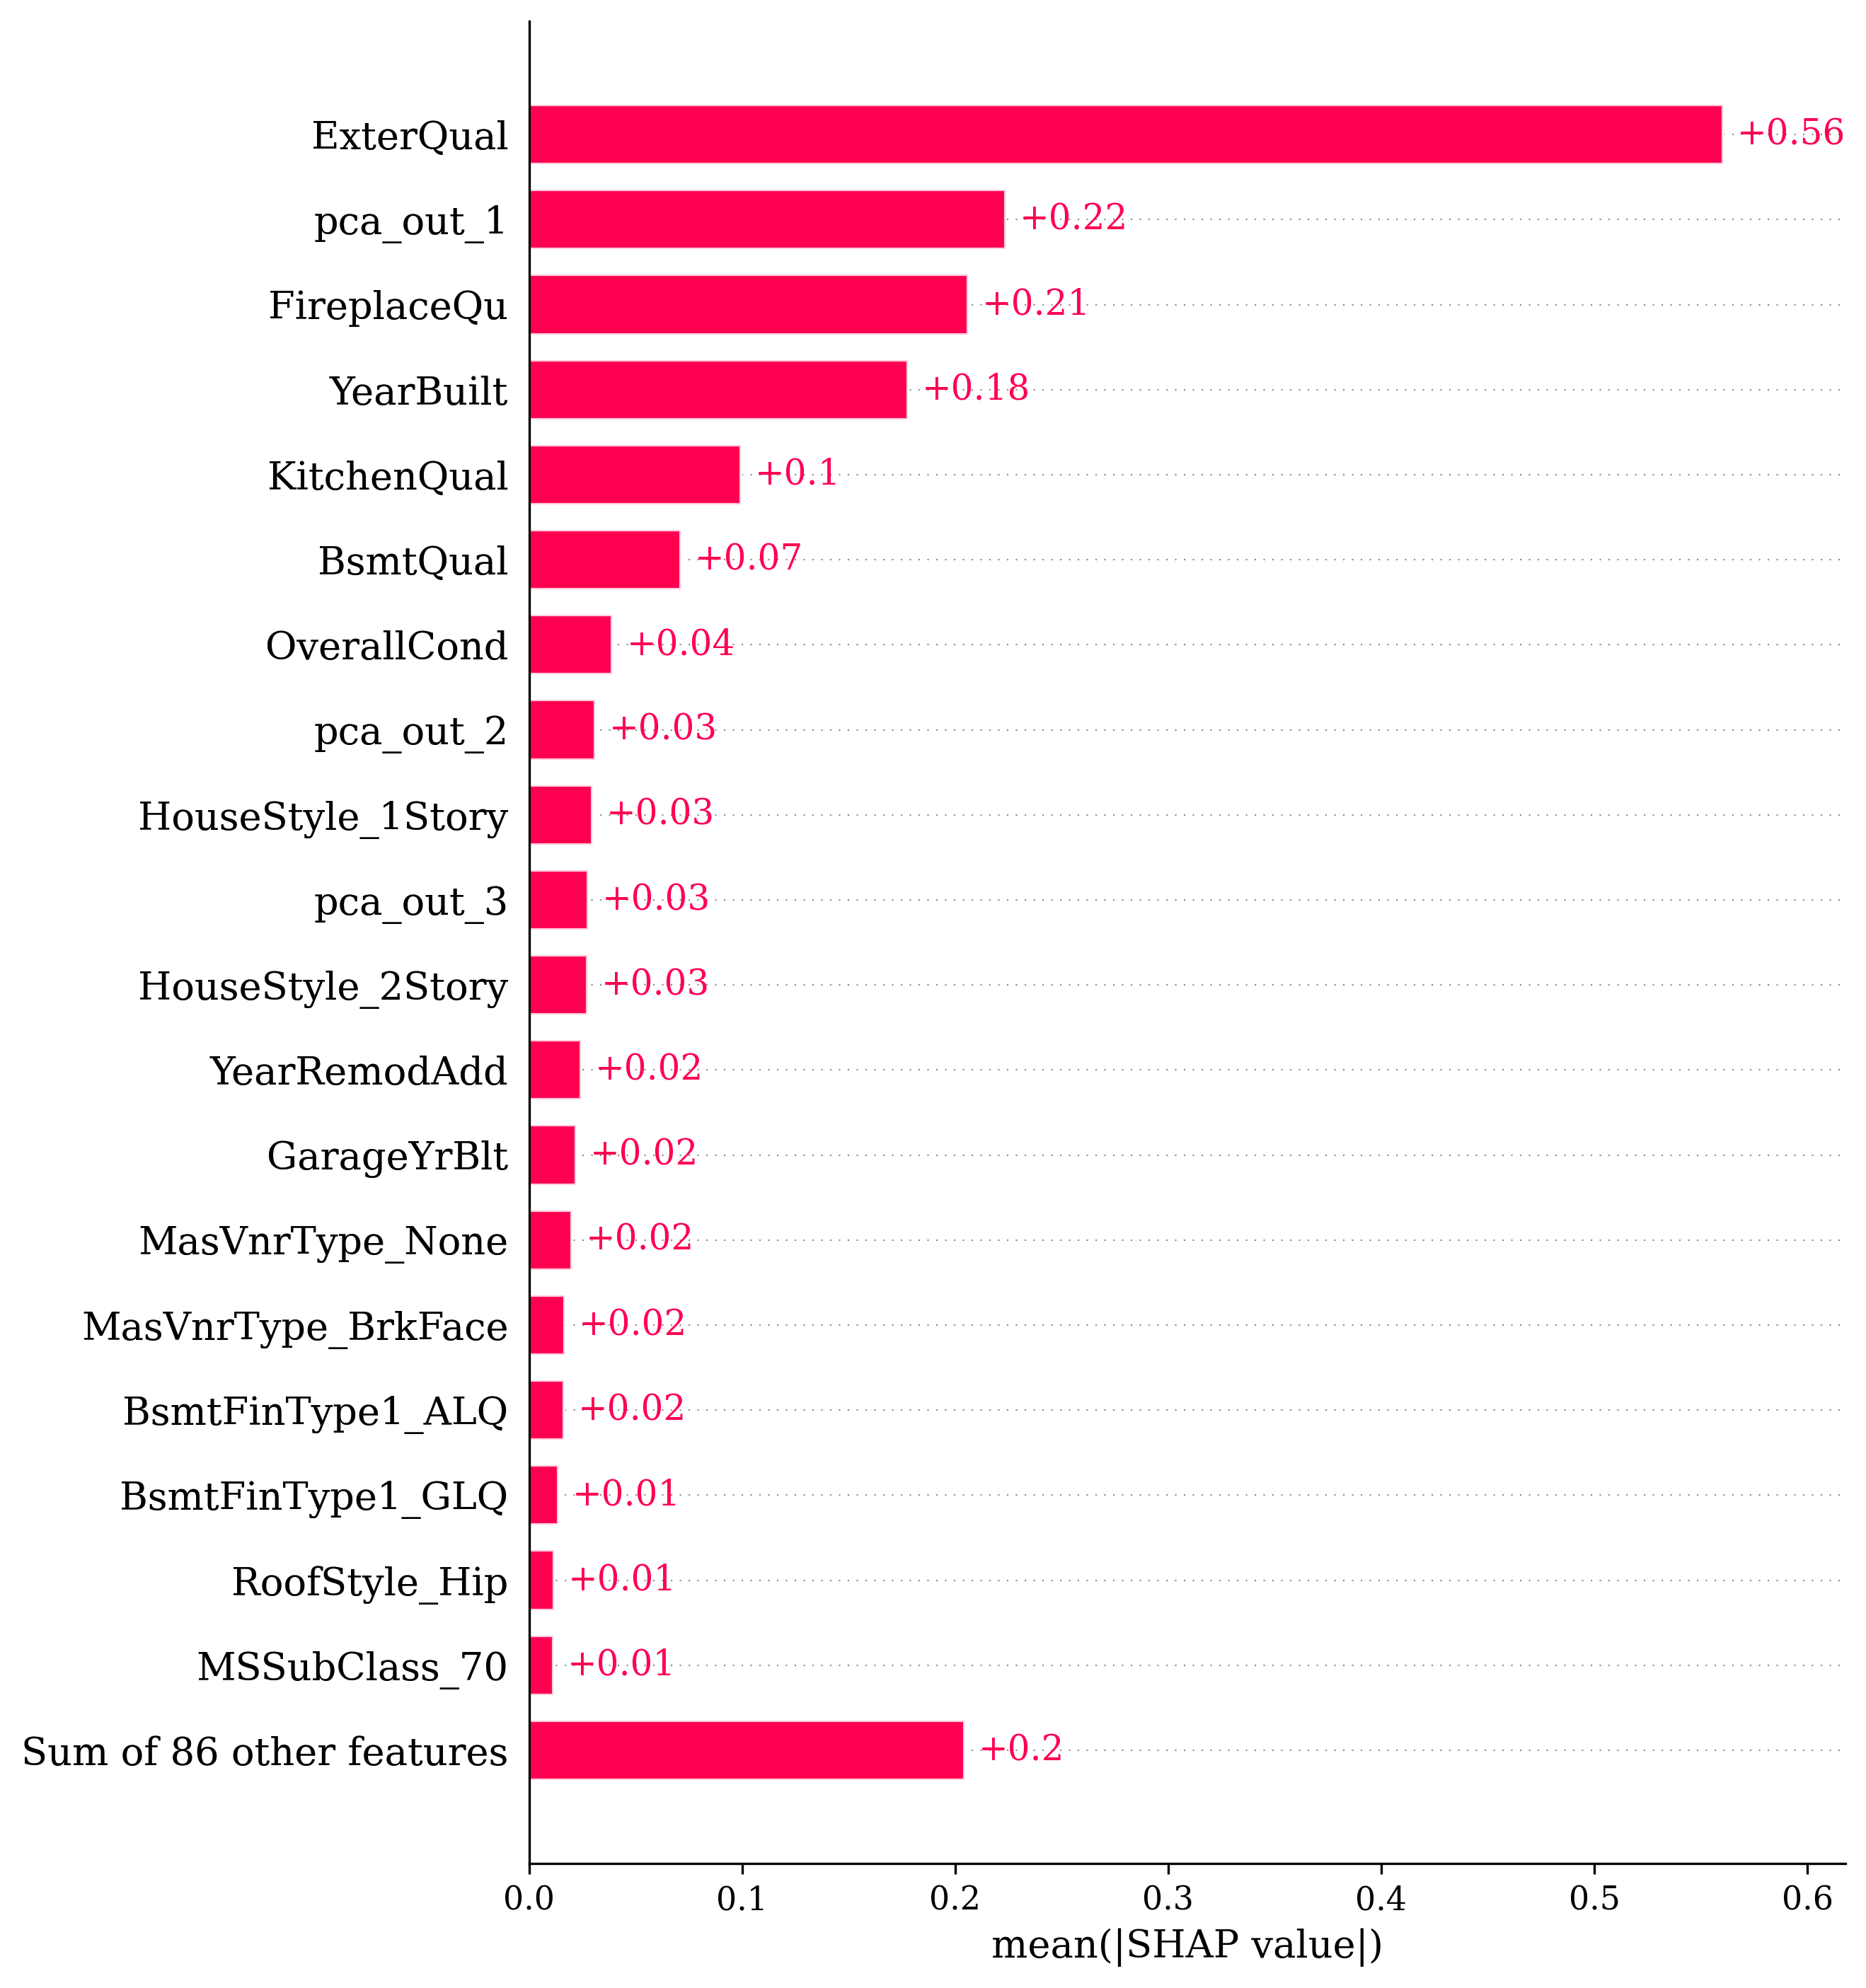

In [30]:
shap.plots.bar(shap_result, max_display=20)

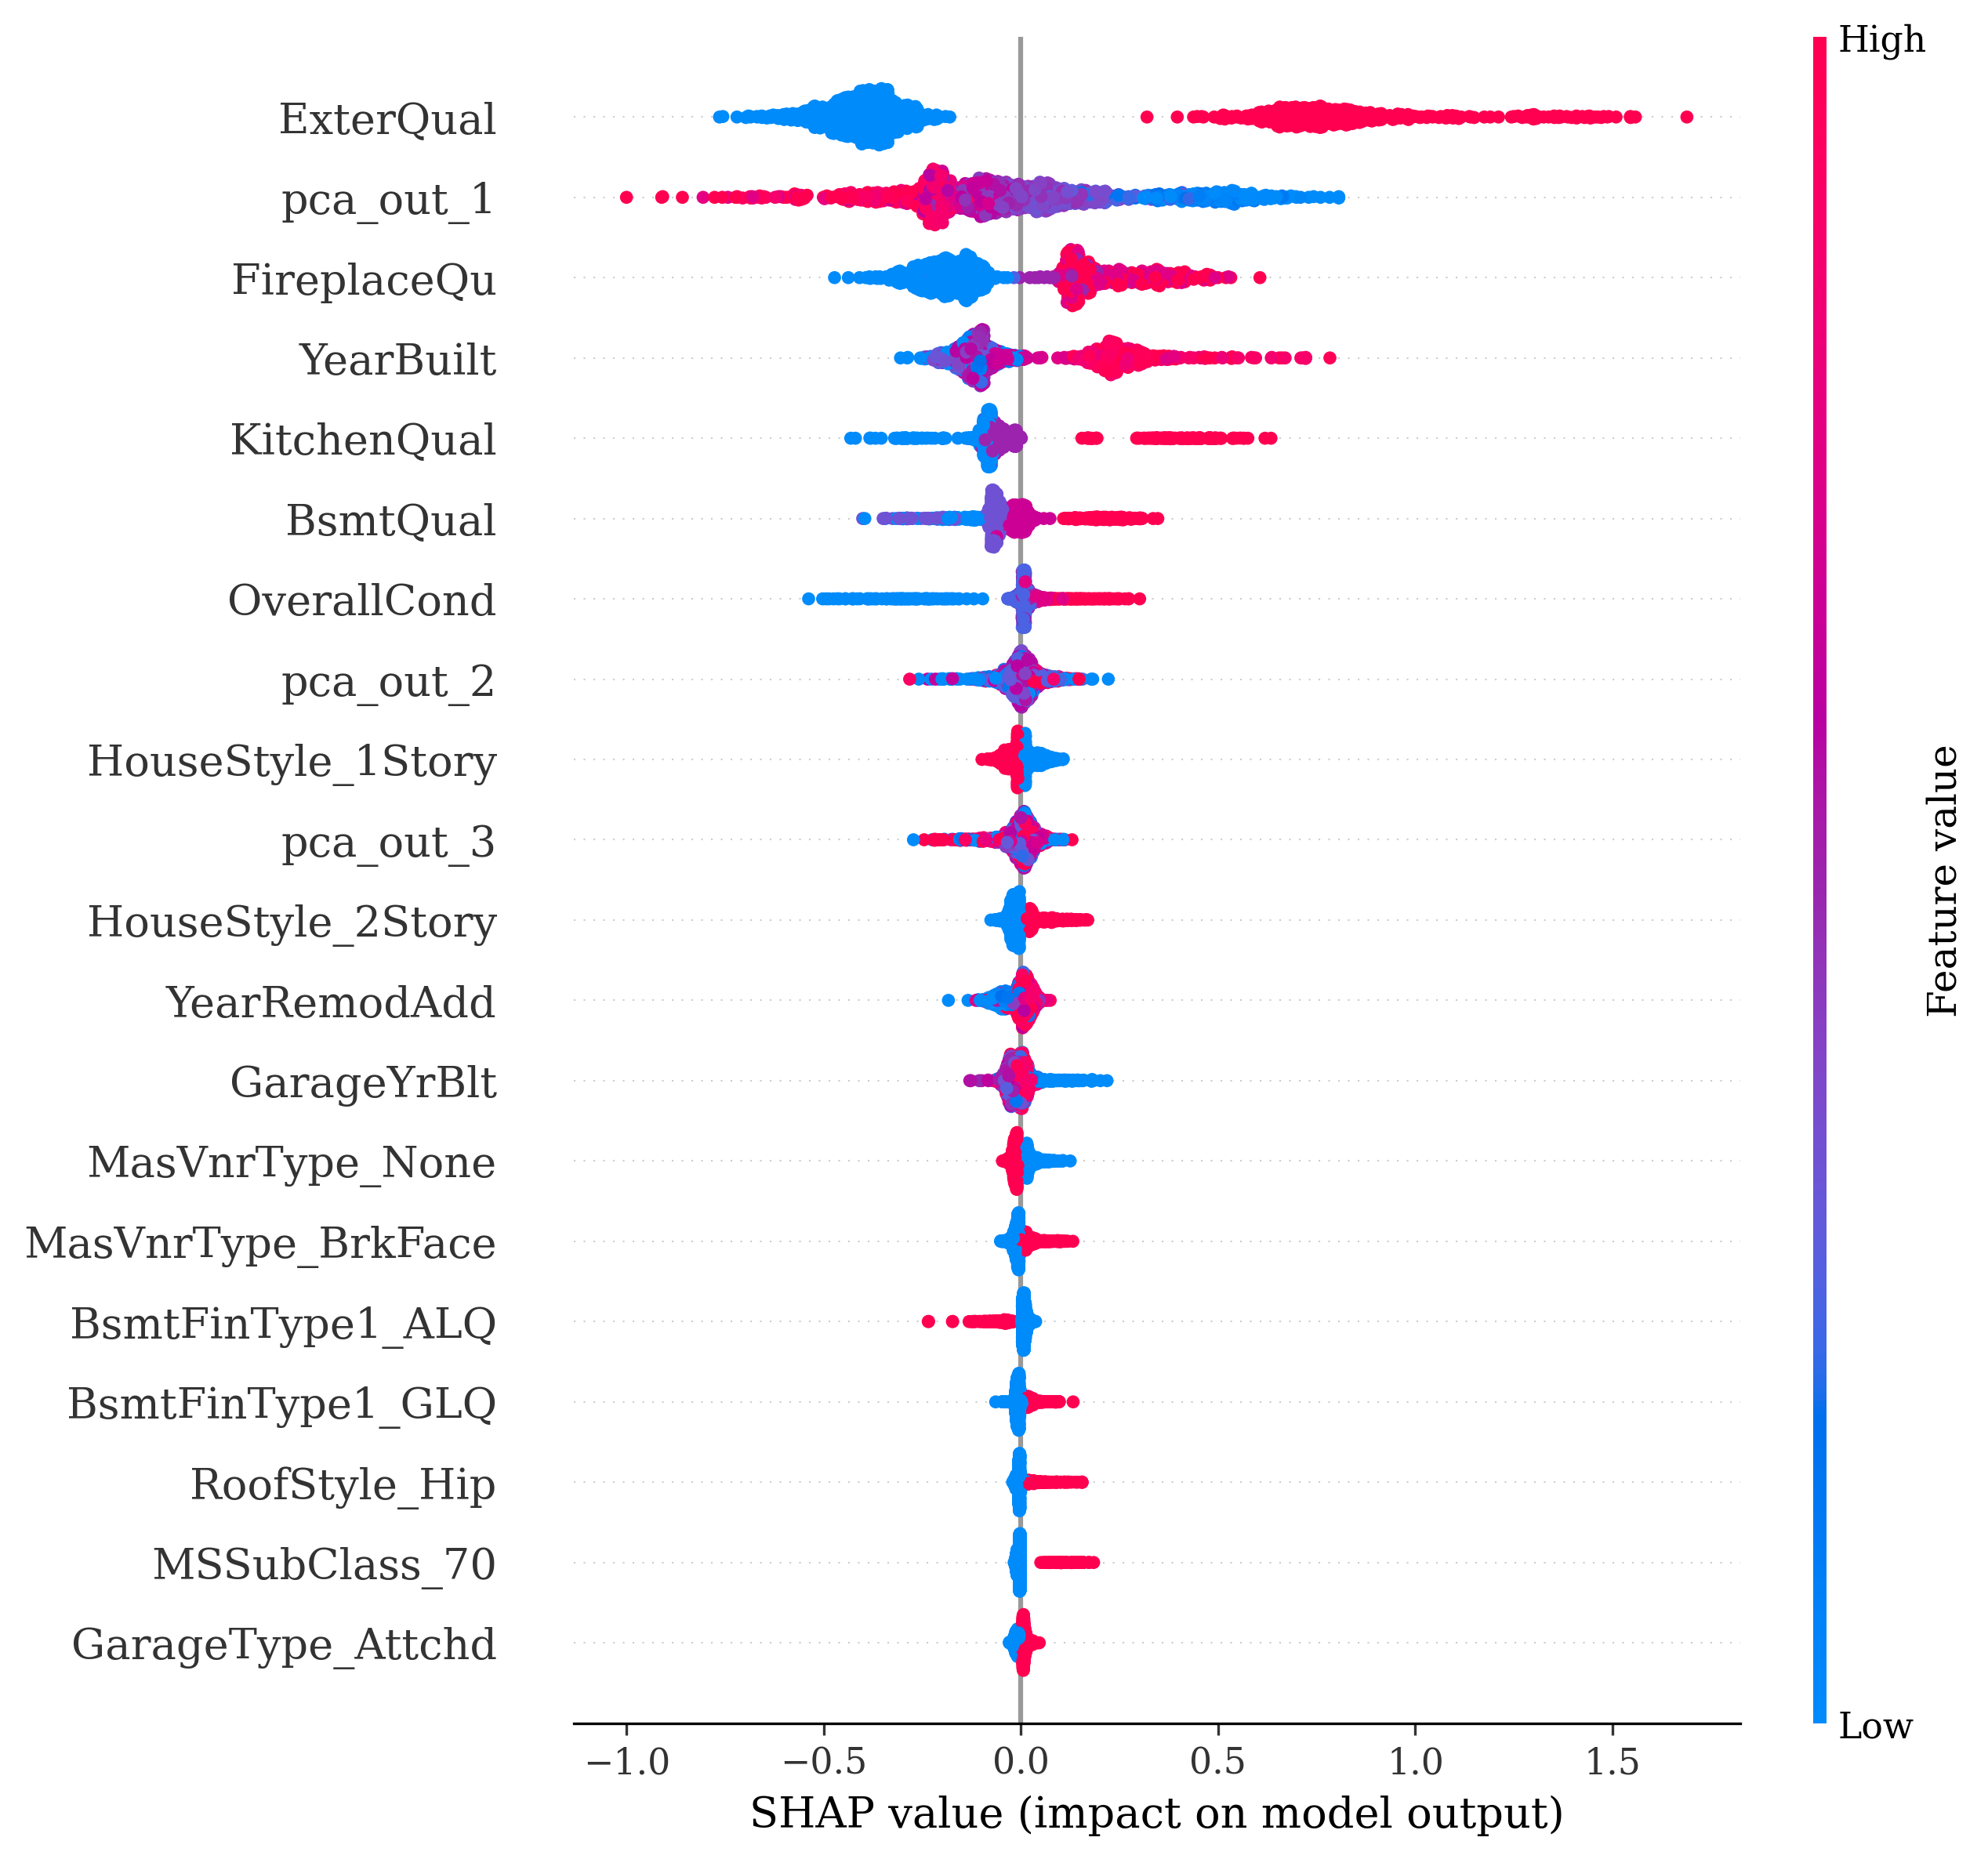

In [31]:
shap.summary_plot(shap_result, x_test_proc)

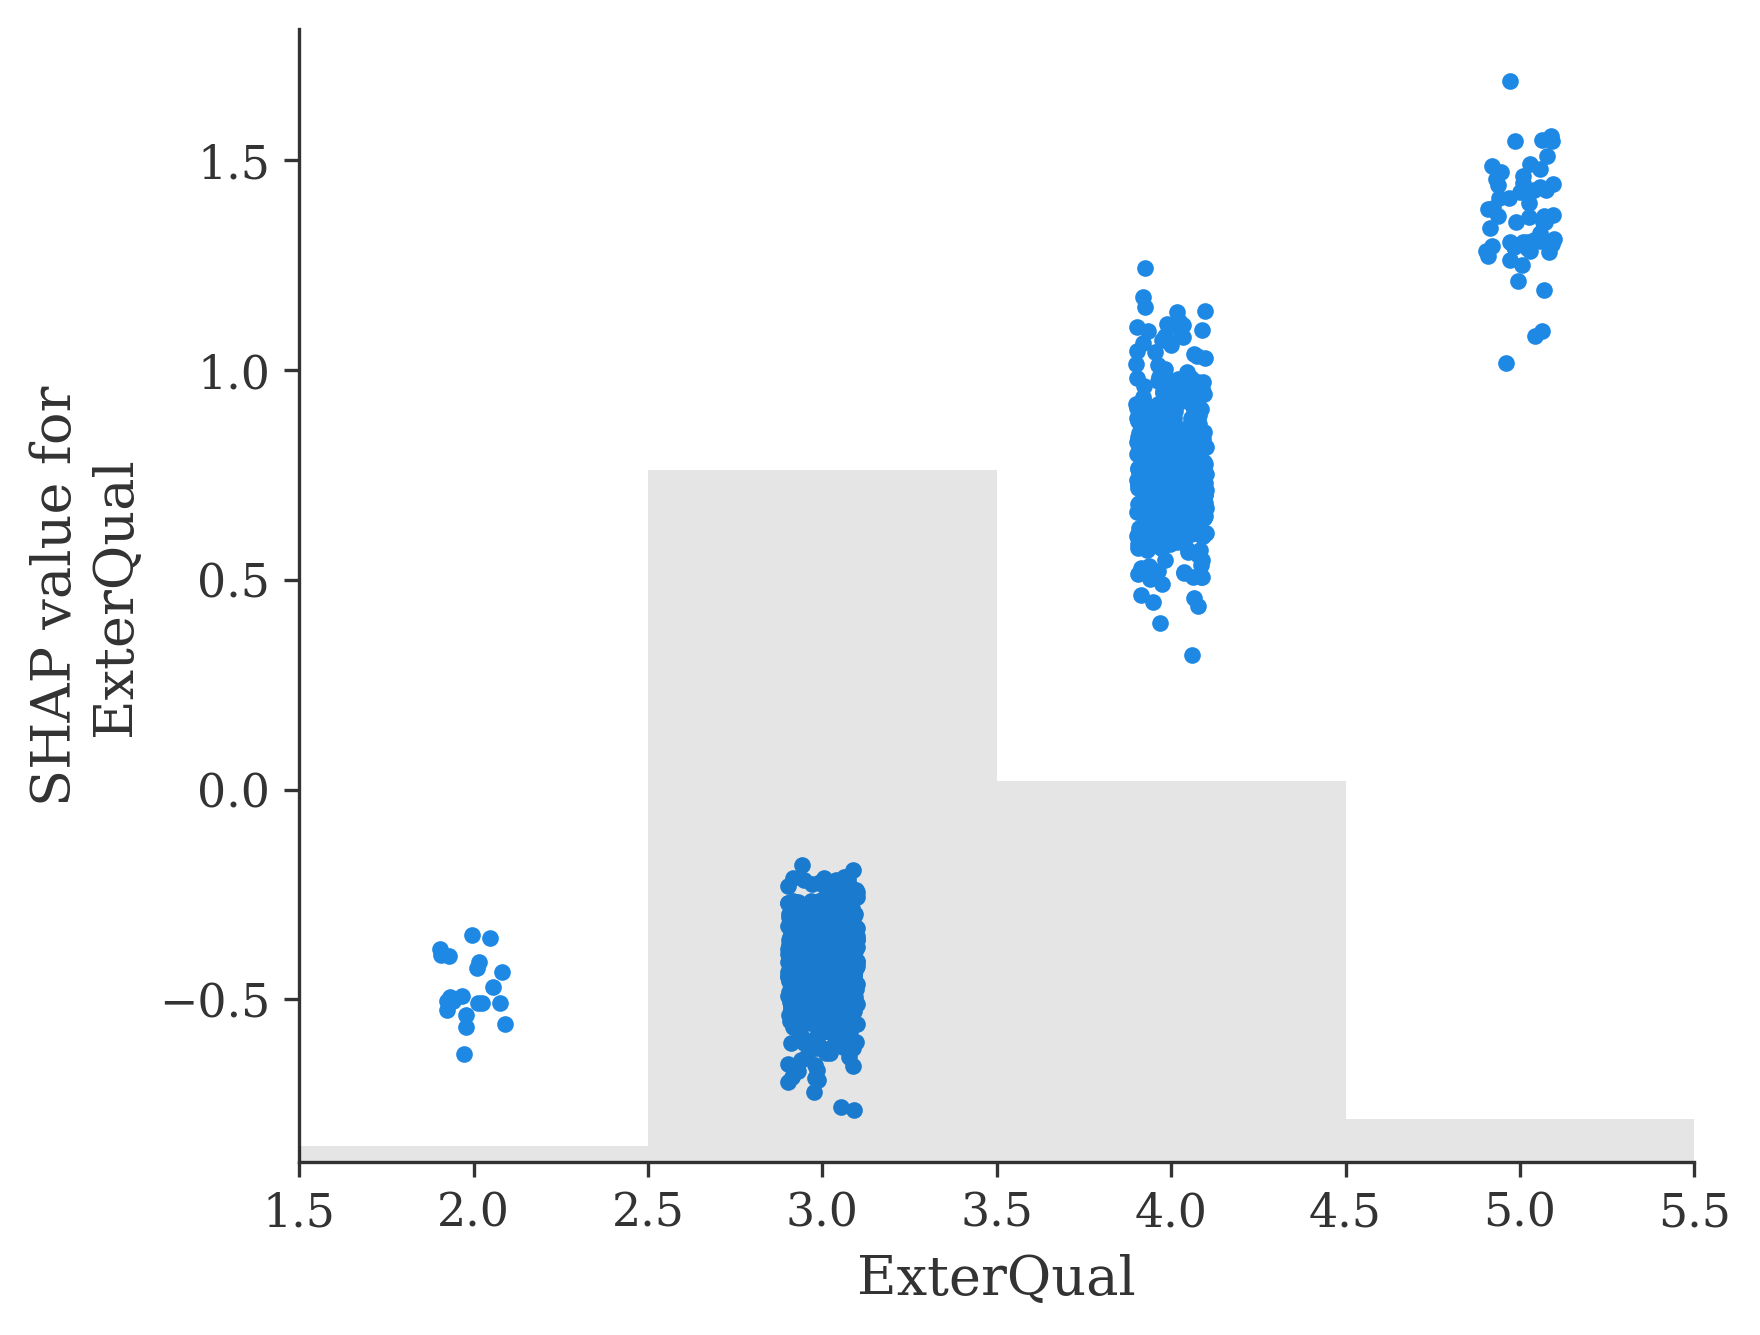

In [32]:
col2idx = {col: idx for idx, col in enumerate(preprocessor.feature_names_out_)}
shap.plots.scatter(shap_result[:, col2idx['ExterQual']])